# Import Library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt
from datetime import datetime
from matplotlib.colors import ListedColormap

# Statistics
import scipy.stats as st

#Encoding 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

#model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import lightgbm as lgb
from lightgbm import LGBMClassifier


#score_metrics & cross validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

#score_metrics & cross validation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix


# Ignore warning
import warnings
warnings.filterwarnings("ignore")

# Load Data

In [2]:
df = pd.read_csv('Clicked Ads Dataset.csv')

In [3]:
df.sample(5)

,Unnamed: 0,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Timestamp,Clicked on Ad,city,province,category
919,919,65.56,25,487524450.0,181.25,Laki-Laki,1/5/2016 12:59,No,Tangerang Selatan,Banten,Health
883,883,41.53,42,473025840.0,158.81,Perempuan,5/23/2016 0:32,Yes,Jakarta Selatan,Daerah Khusus Ibukota Jakarta,Electronic
688,688,74.58,36,494909170.0,230.52,Perempuan,7/22/2016 11:05,No,Jakarta Timur,Daerah Khusus Ibukota Jakarta,Electronic
161,161,82.68,33,438687130.0,222.77,Laki-Laki,6/20/2016 9:35,No,Depok,Jawa Barat,House
480,480,57.11,22,417743480.0,207.17,Laki-Laki,6/7/2016 23:46,No,Samarinda,Kalimantan Timur,Fashion


In [4]:
df = df.rename(columns={'Male':'Gender'})

# Exploratory Data Analysis

In [5]:
missing_value = df.isnull().sum().reset_index()
missing_value.columns = ['Kolom', 'Jumlah Missing Value']
missing_value['Persentase Missing Value'] = missing_value['Jumlah Missing Value']/df.shape[0]*100
fitur = missing_value['Kolom'].unique().tolist()
list=[]
for i in range(0, len(fitur)):
    tipe = missing_value['Kolom'][i]
    tipe_data = df[tipe].dtypes
    list.append(tipe_data)
list
missing_value['Tipe Data'] = list

In [6]:
missing_value = missing_value.sort_values(by='Persentase Missing Value', ascending=False)
missing_value

,Kolom,Jumlah Missing Value,Persentase Missing Value,Tipe Data
1,Daily Time Spent on Site,13,1.3,float64
3,Area Income,13,1.3,float64
4,Daily Internet Usage,11,1.1,float64
5,Gender,3,0.3,object
0,Unnamed: 0,0,0.0,int64
2,Age,0,0.0,int64
6,Timestamp,0,0.0,object
7,Clicked on Ad,0,0.0,object
8,city,0,0.0,object
9,province,0,0.0,object


In [7]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

In [8]:
print(df['Timestamp'].max())
print(df['Timestamp'].min())

2016-07-24 00:22:00
2016-01-01 02:52:00


Melakukan ekstrak dari variabel timestamp, karena hanya data di tahun 2016 sedemikian sehingga akan diekstrak untuk mendapatkan informasi hari dan bulan

In [9]:
df['Day'] = df['Timestamp'].dt.day
df['Month'] = df['Timestamp'].dt.month_name()
df['Day_Name'] = df['Timestamp'].dt.day_name()

In [10]:
df = df.drop('Unnamed: 0', axis=1)

In [11]:
df.sample(5)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Gender,Timestamp,Clicked on Ad,city,province,category,Day,Month,Day_Name
447,73.93,44,519260350.0,218.22,Perempuan,2016-02-20 00:06:00,No,Bandar Lampung,Lampung,Finance,20,February,Saturday
816,36.91,48,382516400.0,159.69,Perempuan,2016-02-24 07:13:00,Yes,Jakarta Selatan,Daerah Khusus Ibukota Jakarta,Bank,24,February,Wednesday
252,84.54,33,454317290.0,204.02,Laki-Laki,2016-03-02 10:07:00,No,Tangerang,Banten,House,2,March,Wednesday
220,77.88,37,387473870.0,254.57,Perempuan,2016-07-02 00:24:00,No,Jakarta Barat,Daerah Khusus Ibukota Jakarta,Fashion,2,July,Saturday
302,39.25,39,436646350.0,152.36,Perempuan,2016-01-23 17:39:00,Yes,Bandung,Jawa Barat,Otomotif,23,January,Saturday


## Duplicated Data

In [12]:
df.duplicated().sum()

0

- Tidak ada data duplikat

### Memisahkan variabel berdasarkan tipe datanya

In [13]:
categoric = df.loc[:, df.dtypes==np.object]
numeric = df.loc[:, df.dtypes!=np.object]
numeric = numeric.drop('Timestamp', axis=1)
timestamp = df[['Timestamp']]

## Descriptive Statistics

In [14]:
numeric.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Day
count,987.000000,1000.000000,9.870000e+02,989.000000,1000.000000
mean,64.929524,36.009000,3.848647e+08,179.863620,15.484000
std,15.844699,8.785562,9.407999e+07,43.870142,8.734073
min,32.600000,19.000000,9.797550e+07,104.780000,1.000000
25%,51.270000,29.000000,3.286330e+08,138.710000,8.000000
50%,68.110000,35.000000,3.990683e+08,182.650000,15.000000
75%,78.460000,42.000000,4.583554e+08,218.790000,23.000000
max,91.430000,61.000000,5.563936e+08,267.010000,31.000000


In [15]:
categoric.describe()

,Gender,Clicked on Ad,city,province,category,Month,Day_Name
count,997,1000,1000,1000,1000,1000,1000
unique,2,2,30,16,10,7,7
top,Perempuan,No,Surabaya,Daerah Khusus Ibukota Jakarta,Otomotif,February,Sunday
freq,518,500,64,253,112,160,159


In [16]:
timestamp.describe()

,Timestamp
count,1000
unique,997
top,2016-05-26 15:40:00
freq,2
first,2016-01-01 02:52:00
last,2016-07-24 00:22:00


## Handling Missing Value

- Missing value pada variabel numerik akan diinput dengan Median
- Missing value pada variabel Gender akan diinput dengan Modus 

In [17]:
df['Daily Time Spent on Site'].fillna(df['Daily Time Spent on Site'].quantile(0.50), inplace=True)
df['Area Income'].fillna(df['Area Income'].quantile(0.50), inplace=True)
df['Daily Internet Usage'].fillna(df['Daily Internet Usage'].quantile(0.50), inplace=True)
df['Gender'].fillna('Perempuan', inplace=True)

In [18]:
df.isnull().sum()

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Gender                      0
Timestamp                   0
Clicked on Ad               0
city                        0
province                    0
category                    0
Day                         0
Month                       0
Day_Name                    0
dtype: int64

## Univariate Analysis

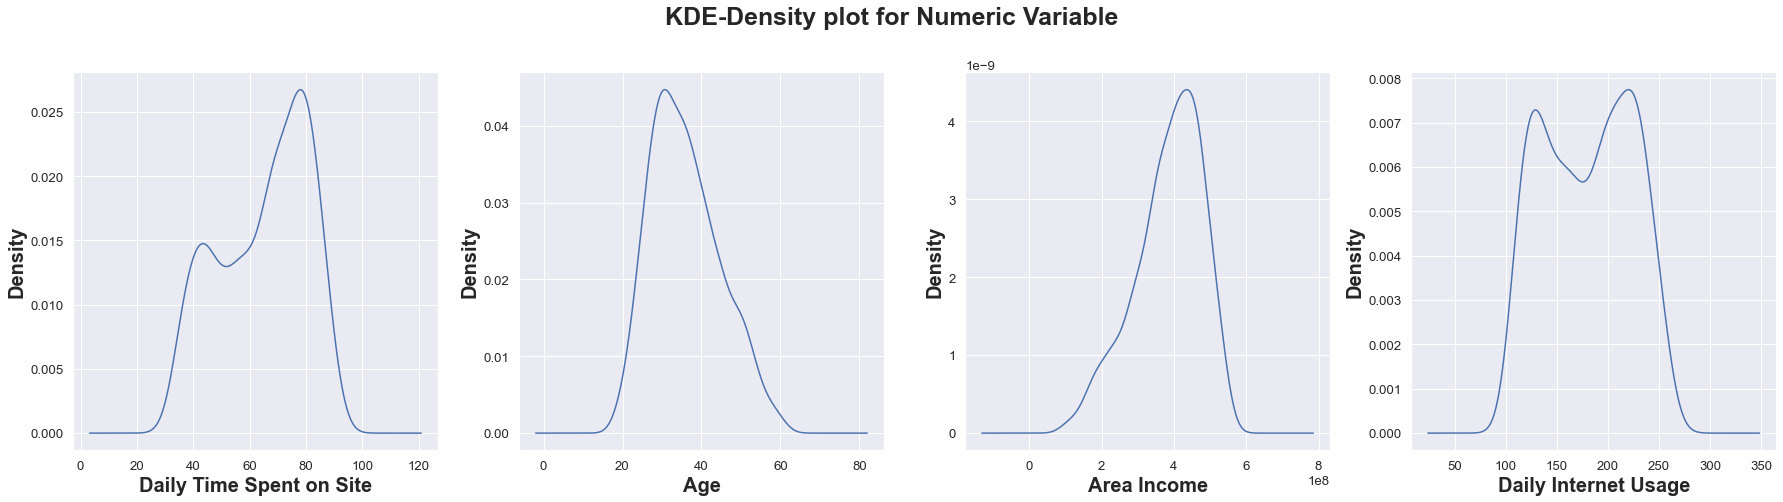

In [19]:
fitur = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']

for i in range(0, len(fitur)):
    plt.rcParams["figure.figsize"] = (25,7)
    sns.set(font_scale=1.2)
    plt.subplot(1,4,i+1)
    df[fitur[i]].plot.kde()
    plt.xlabel(fitur[i],weight='bold', fontsize=20)
    plt.ylabel('Density', weight='bold', fontsize=20)
    plt.suptitle('KDE-Density plot for Numeric Variable', weight='bold', fontsize=25, y=1)
    plt.tight_layout()

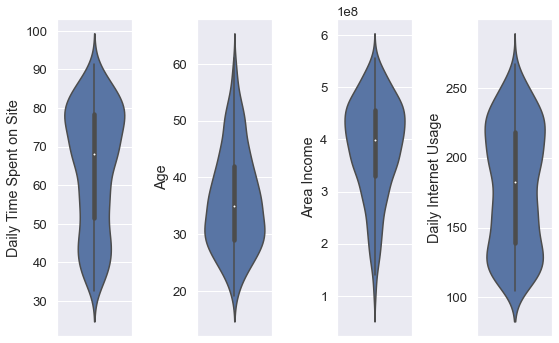

In [20]:
fitur = ['Daily Time Spent on Site','Age', 'Area Income', 'Daily Internet Usage']

for i in range(0, len(fitur)):
    plt.rcParams['figure.figsize'] = (8,5)
    plt.subplot(1,len(fitur),i+1)
    sns.violinplot(y=df[fitur[i]])
    plt.tight_layout()  

- Variabel Daily time spent on site dan Daily Internet Usage memiliki distribusi yang cenderung bimodal 
- Variabel Age memiliki distribusi cenderung positively skewed, sedangkan variable Area Income memiliki distribusi negatively skewed
- Sebagian besar customer menghabiskan waktu berada di platform/situs antara 60-80 menit
Usia customer adalah sekitar 20 - 60 tahun
- Sebagian besar customer memiliki pendapatan antara 300 juta – 500 juta 
Penggunaan harian internet adalah 100 – 250 menit per hari.



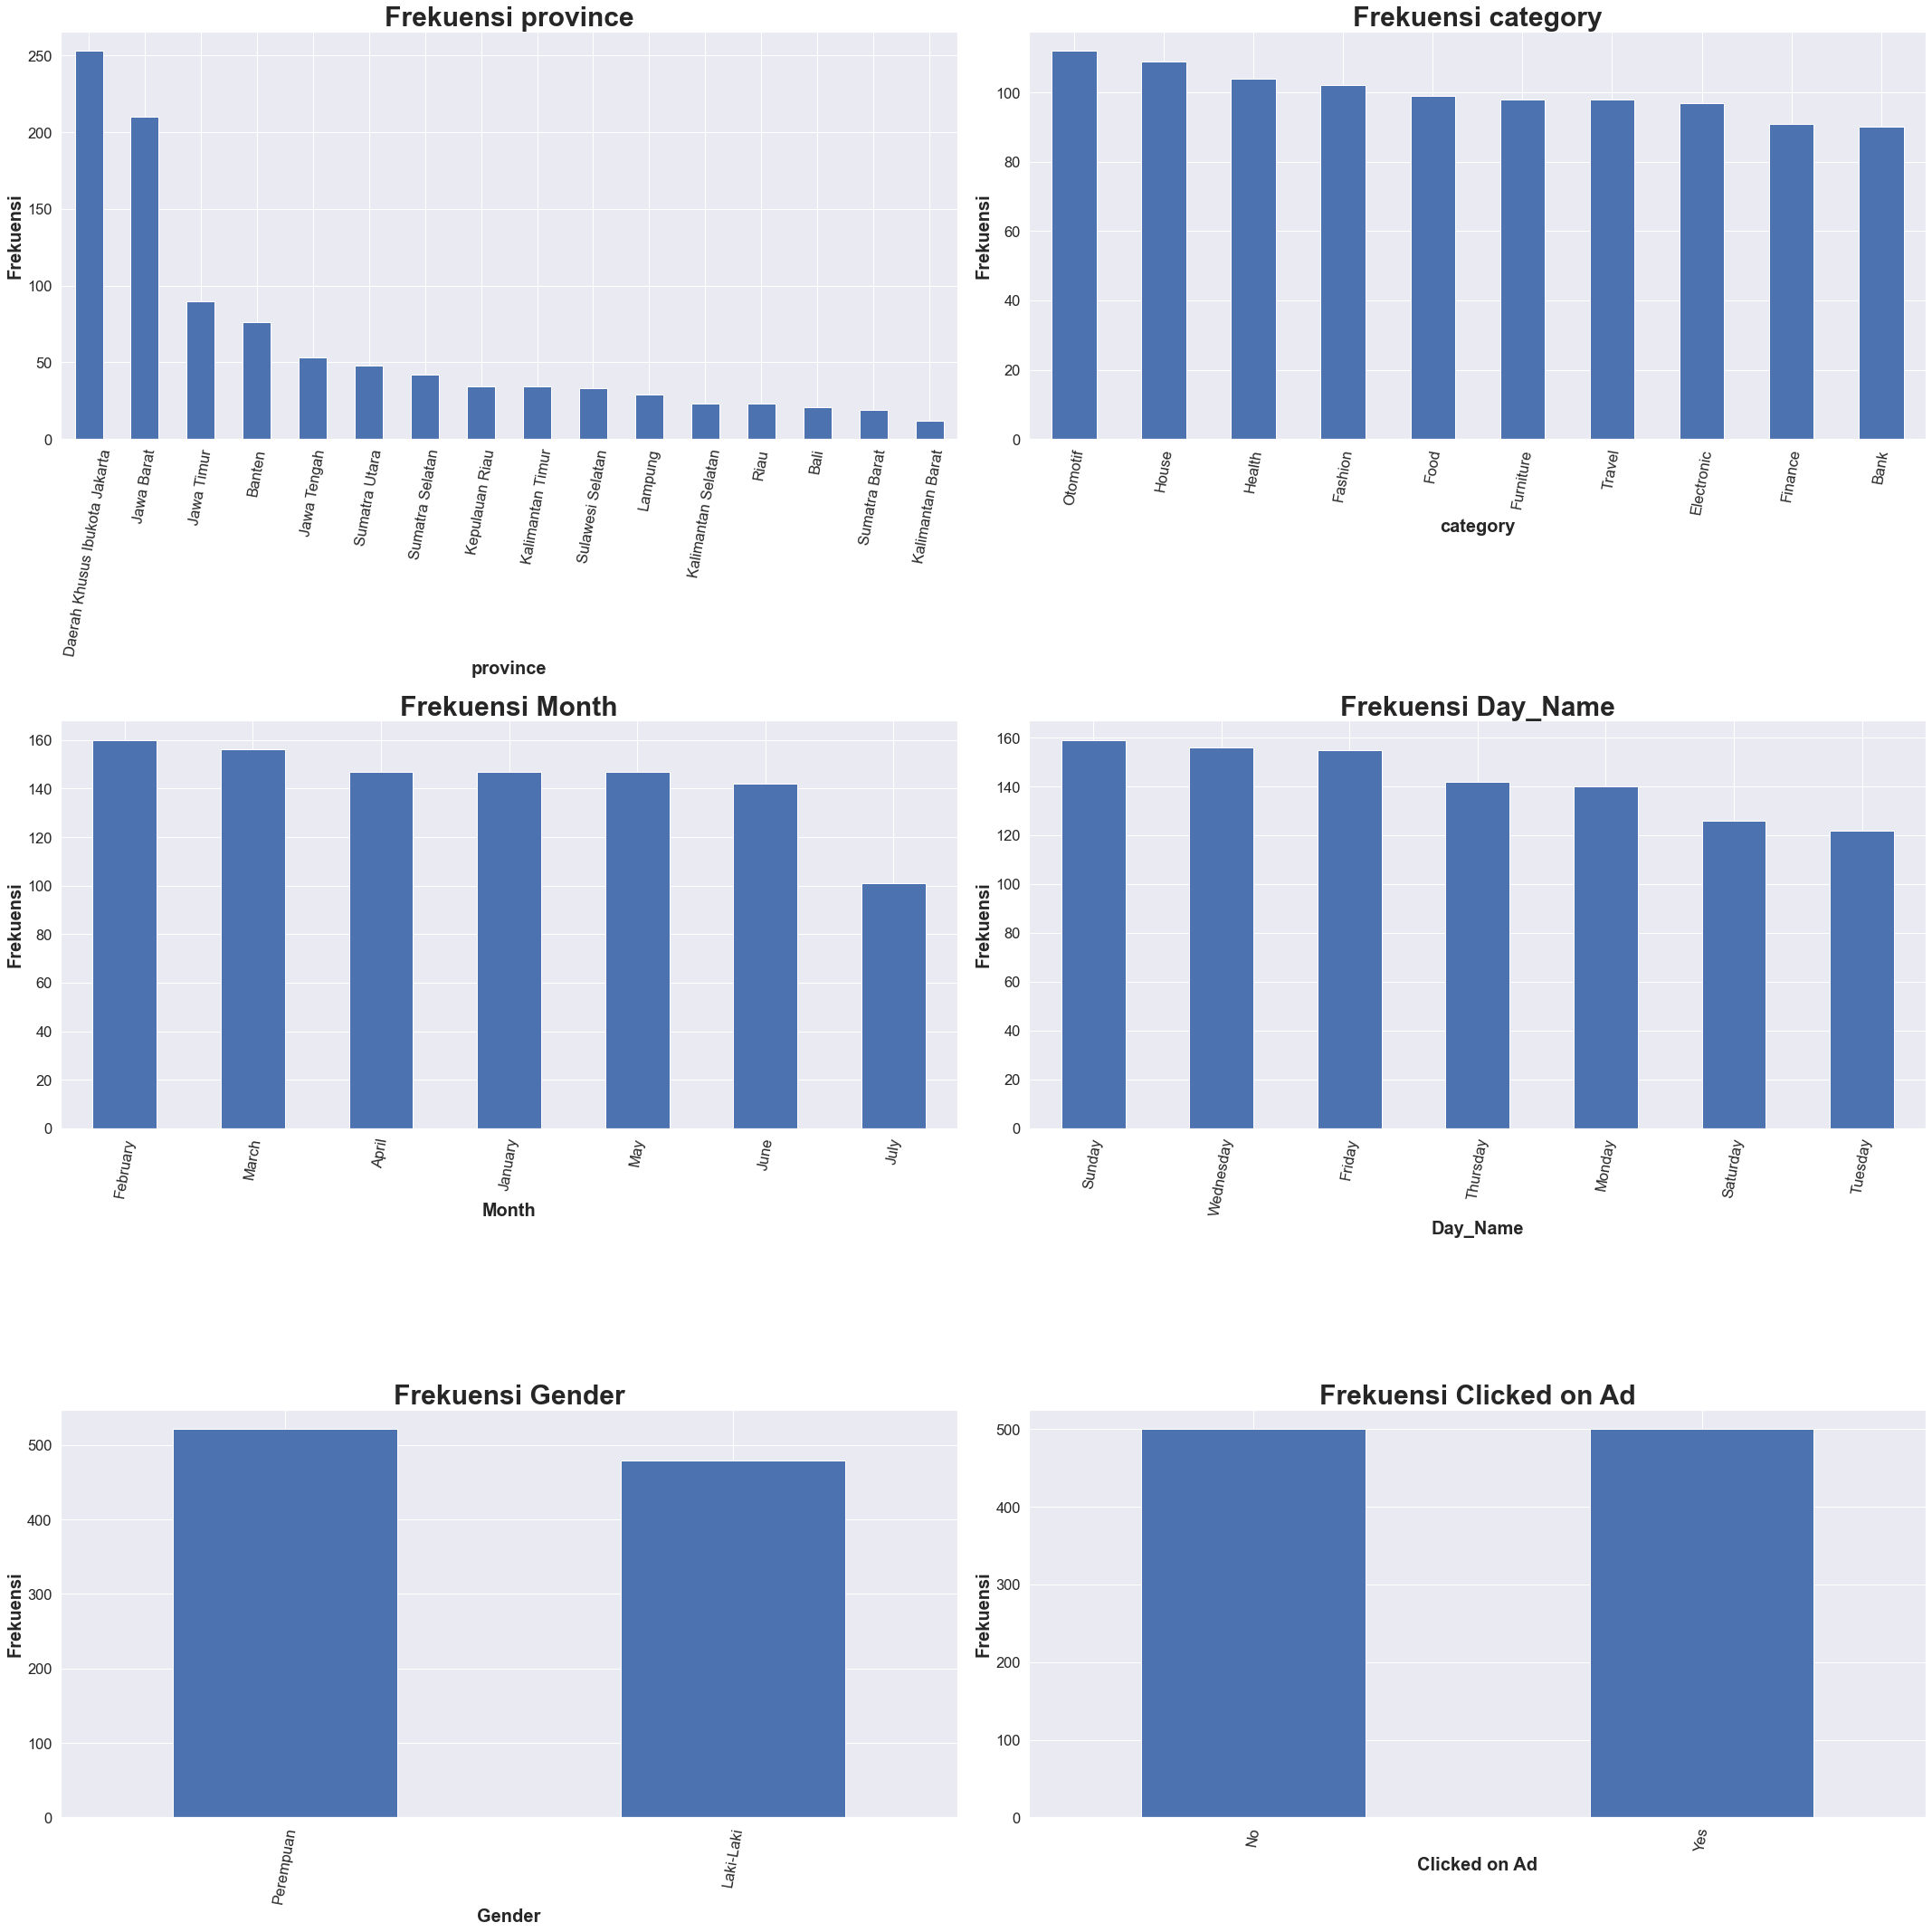

In [21]:
features = ['province', 'category', 'Month', 'Day_Name','Gender', 'Clicked on Ad']
for i in range(0, len(features)):
    plt.rcParams['figure.figsize'] = (30, 30)
    sns.set(font_scale=1.5)
    plt.subplot(3,2,i+1)
    value_counts = df[features[i]].value_counts()
    value_counts.plot(kind='bar')
    plt.title("Frekuensi "+features[i], fontsize=30, weight='bold')
    plt.xlabel(features[i], fontsize=20, weight='bold')
    plt.ylabel('Frekuensi', fontsize=20, weight='bold')
    plt.xticks(rotation = 80)
    plt.tight_layout()

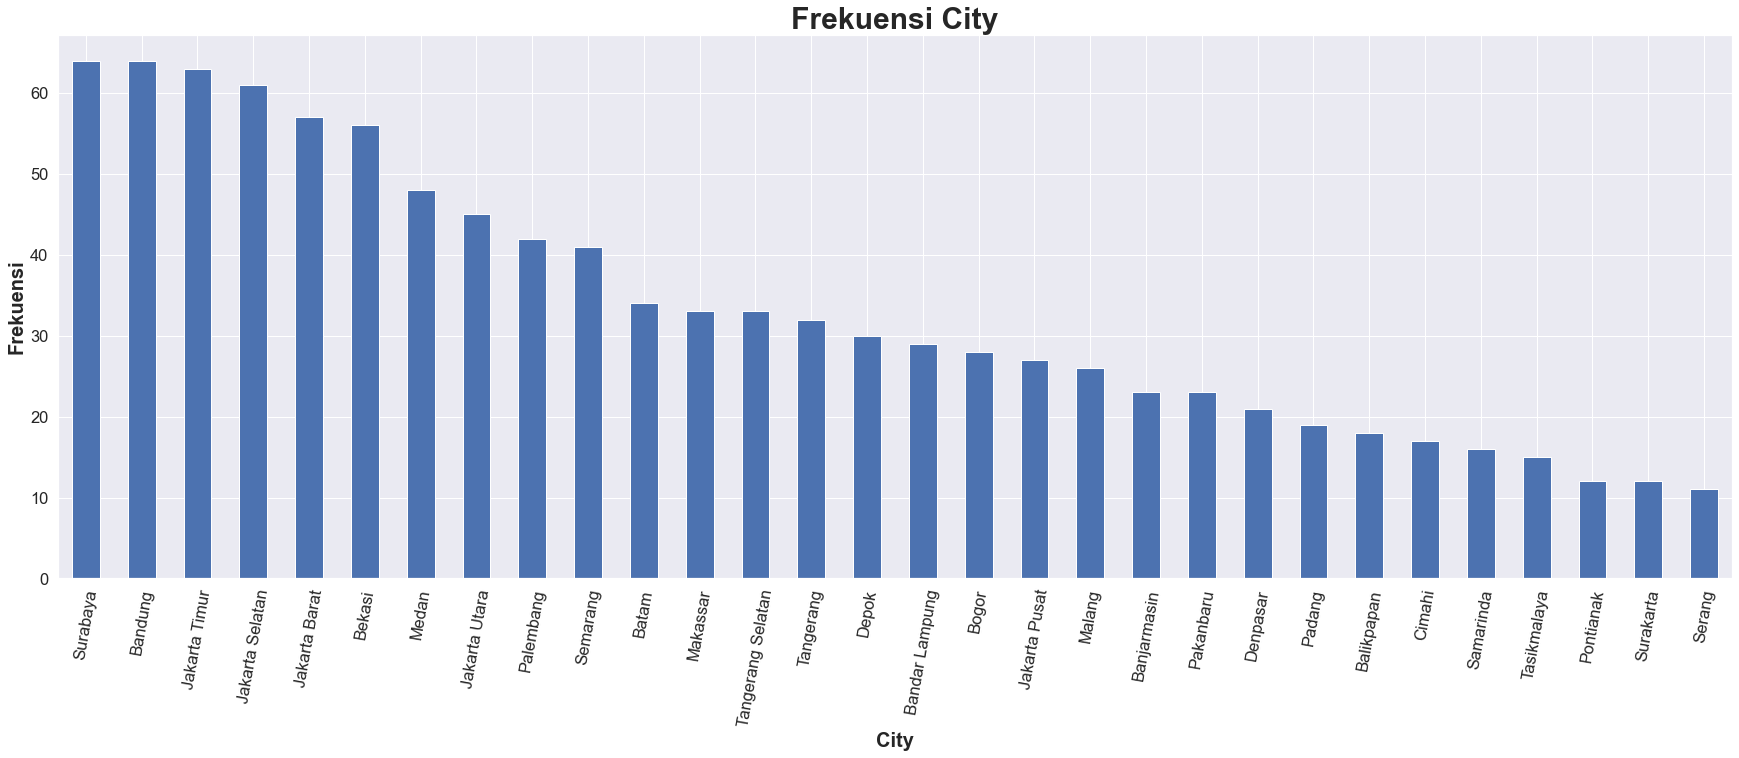

In [22]:
plt.rcParams['figure.figsize'] = (30, 10)
sns.set(font_scale=1.5)
value_counts = df['city'].value_counts().plot(kind='bar')
plt.title("Frekuensi City", fontsize=30, weight='bold')
plt.xlabel("City", fontsize=20, weight='bold')
plt.ylabel('Frekuensi', fontsize=20, weight='bold')
plt.xticks(rotation = 80)
plt.show()

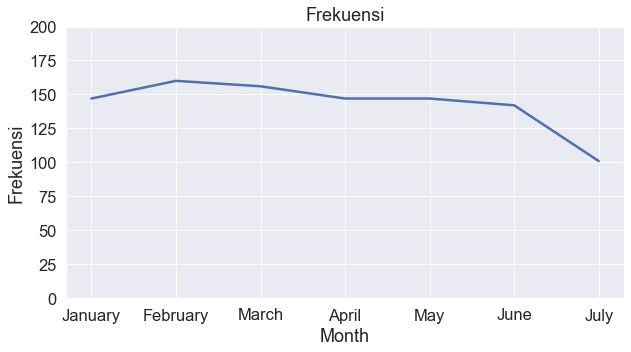

In [23]:
timestamp = df.groupby(['Month']).agg({'Gender':['count']}).reset_index()
timestamp.columns = ['Month','Frekuensi']
months = ['January','February','March','April','May','June',
         'July','August','September','October','November','December']
timestamp['Month'] = pd.Categorical(timestamp['Month'], categories=months, ordered=True)

plt.rcParams["figure.figsize"] = (10,5)
sns.lineplot(timestamp['Month'],timestamp['Frekuensi'],palette="tab10", linewidth=2.5)
plt.title('Frekuensi')
plt.ylim(0,200)
plt.show()

## Bivariate Analysis

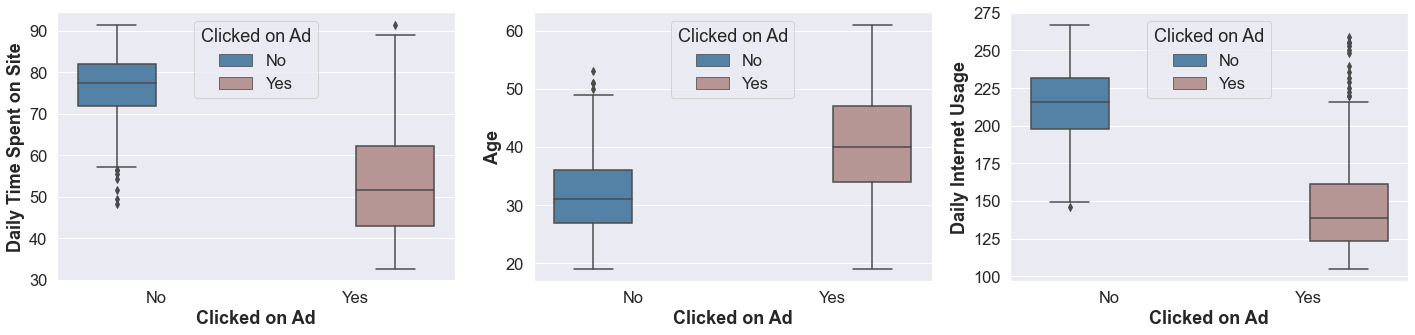

In [24]:
features = ['Daily Time Spent on Site', 'Age', 'Daily Internet Usage']
for i in range(0, len(features)):
    my_colors = ['Steelblue','Rosybrown']
    sns.set_palette(my_colors) 
    plt.rcParams['figure.figsize'] = (20,5)
    plt.subplot(1,3,i+1)
    sns.boxplot(y=features[i], x='Clicked on Ad',hue='Clicked on Ad', data=df)
    plt.xlabel('Clicked on Ad',weight='bold')
    plt.ylabel(features[i],weight='bold')
    plt.legend(title ='Clicked on Ad', loc = 'upper center')
    plt.tight_layout()    

- Sebagian besar customer yang menghabiskan waktunya untuk berada di internet dan melakukan clicked pada iklan adalah customer yang berusia di antara 35 - 50 tahun. Sedangkan customer yang berusia antara 27-35 tahun sebagian besar tidak melakukan klik pada iklan. 
- Semakin lama waktu yang dihabiskan untuk berada di situs, customer cenderung tidak melakukan klik pada iklan.
- Semakin tinggi penggunaan internet, cenderung untuk tidak melakukan klik pada iklan yang ada pada situs 

<Figure size 3600x1080 with 0 Axes>

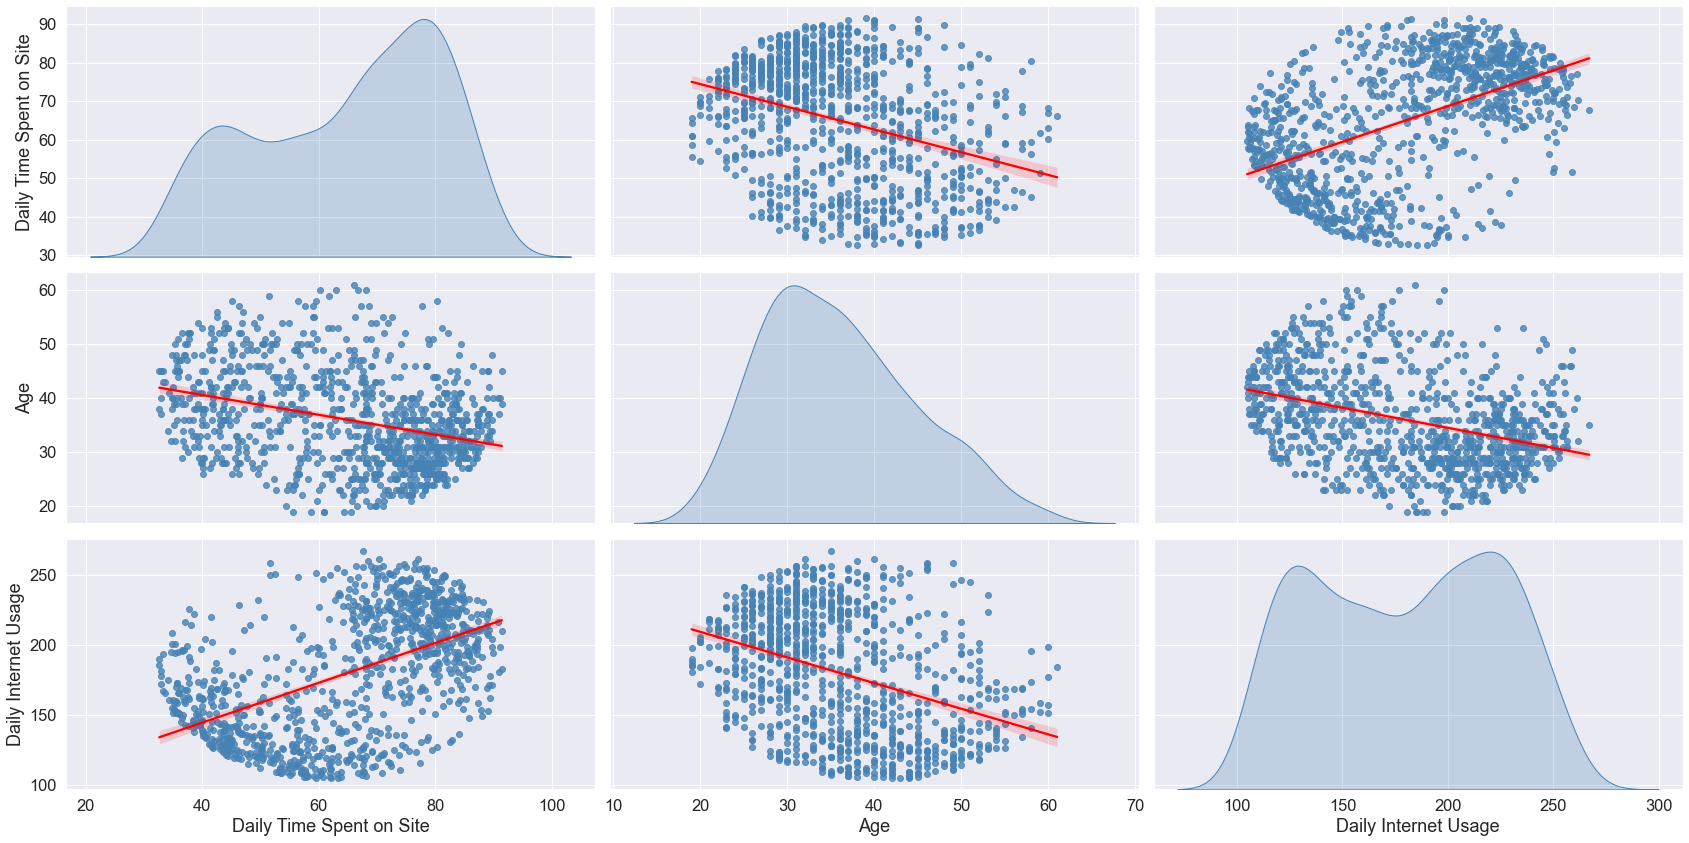

In [25]:
features = df[['Daily Time Spent on Site', 'Age', 'Daily Internet Usage']]
plt.figure(figsize=(50, 15))
sns.pairplot(features, diag_kind='kde', kind="reg",plot_kws={'line_kws':{'color':'red'}}, height=4, aspect=2) 

- Semakin tinggi usia customer penggunaan internet harian semakin sebentar 
- Semakin tinggi usia customer, waktu harian yang dihabiskan untuk berada di situe juga semakin sebentar 
- Semakin tinggi penggunaan harian internet, waktu harian yang dihabiskan untuk berada di situs juga semakin lama

In [26]:
def stackedbar(variabel):
    
    df_rate = categoric[[variabel,'Clicked on Ad']]
    df_rate

    cross_tab_prop = pd.crosstab(index=df_rate[variabel],
                                 columns=df_rate['Clicked on Ad'],
                                 normalize="index")
    cross_tab_prop = cross_tab_prop[['Yes','No']]
    cross_tab_prop = cross_tab_prop.sort_values(by='Yes', ascending=False).head(30)
    cross_tab_prop

    cross_tab_prop.plot(kind='bar', stacked=True, color=['Rosybrown','Steelblue'],figsize=(30, 8))

    plt.legend(loc="upper center",ncol=5,title='Clicked on Ad', fontsize = 15)
    sns.set(font_scale=1.5)
    plt.axhline(y = categoric['Clicked on Ad'].value_counts(True)[0], color ="red", linestyle ="--")
    plt.text(x=-0.5,y=1.42,s="Proportion customer clicked on ad based on" + ' ' + variabel,fontsize=25,weight='bold')
    plt.text(x=0.27,y=cross_tab_prop['No'].mean()-0.05,s='Proportion customer clicked on Ad overall',fontsize=14,weight='bold')
    plt.xlabel(variabel,fontsize = 20,weight='bold')
    plt.ylabel("Proportion",fontsize = 20,weight='bold')
    plt.ylim(0,1.4)
    plt.xticks(rotation = 0)
    for n, x in enumerate([*cross_tab_prop.index.values]):
        for (proportion, y_loc) in zip(cross_tab_prop.loc[x],
                                       cross_tab_prop.loc[x].cumsum()):

            plt.text(x=n - 0.15,
                     y=(y_loc - proportion)*1.06 + (proportion / 2),
                     s=f'{np.round(proportion * 100, 1)}%', 
                     color="White",
                     fontsize=15,
                     fontweight="bold")

    plt.show()

In [27]:
def stackedbar1(variabel):
    
    df_rate = categoric[[variabel,'Clicked on Ad']]
    df_rate

    cross_tab_prop = pd.crosstab(index=df_rate[variabel],
                                 columns=df_rate['Clicked on Ad'],
                                 normalize="index")
    cross_tab_prop = cross_tab_prop[['Yes','No']]
    cross_tab_prop = cross_tab_prop.sort_values(by='Yes', ascending=False).head(30)
    cross_tab_prop


    cross_tab_prop.plot(kind='bar', stacked=True, color=['Rosybrown','Steelblue'],figsize=(30, 8))

    plt.legend(loc="upper center",ncol=5,title='Clicked on Ad', fontsize = 15)
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid')
    plt.axhline(y = categoric['Clicked on Ad'].value_counts(True)[0], color ="red", linestyle ="--")
    plt.text(x=-0.5,y=1.42,s="Proportion customer clicked on ad based on" + ' ' + variabel,fontsize=25,weight='bold')
    plt.text(x=0.27,y=cross_tab_prop['No'].mean()-0.05,s='Proportion customer clicked on Ad overall',fontsize=14,weight='bold')
    plt.xlabel(variabel,fontsize = 20,weight='bold', y=-0.2)
    plt.ylabel("Proportion",fontsize = 20,weight='bold')
    plt.ylim(0,1.4)
    plt.xticks(rotation = 70)
    plt.show()

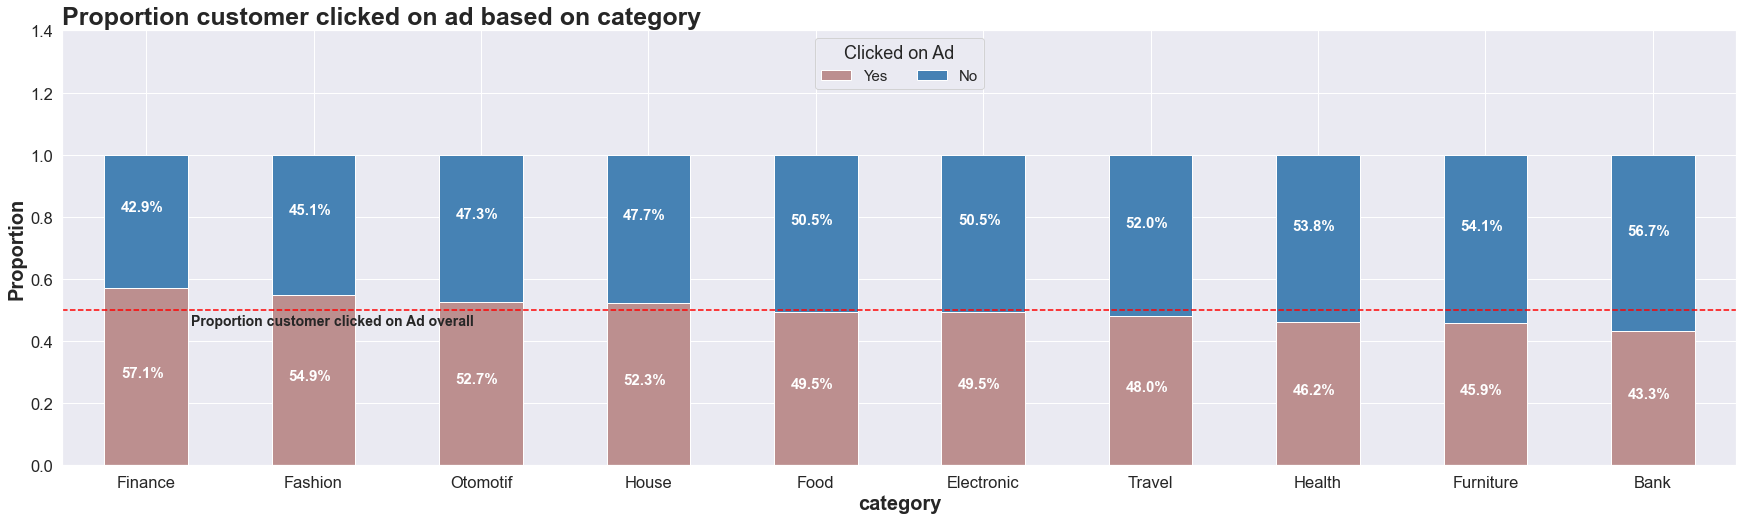

In [28]:
stackedbar('category')

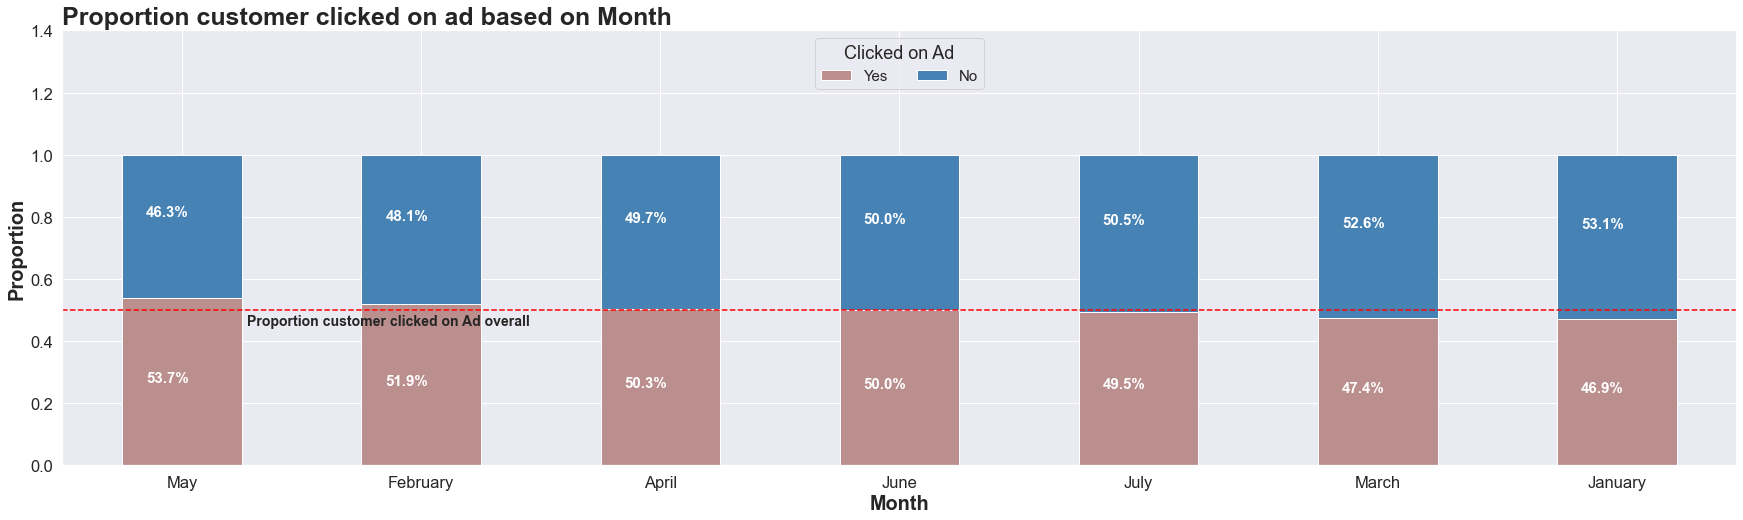

In [29]:
stackedbar('Month')

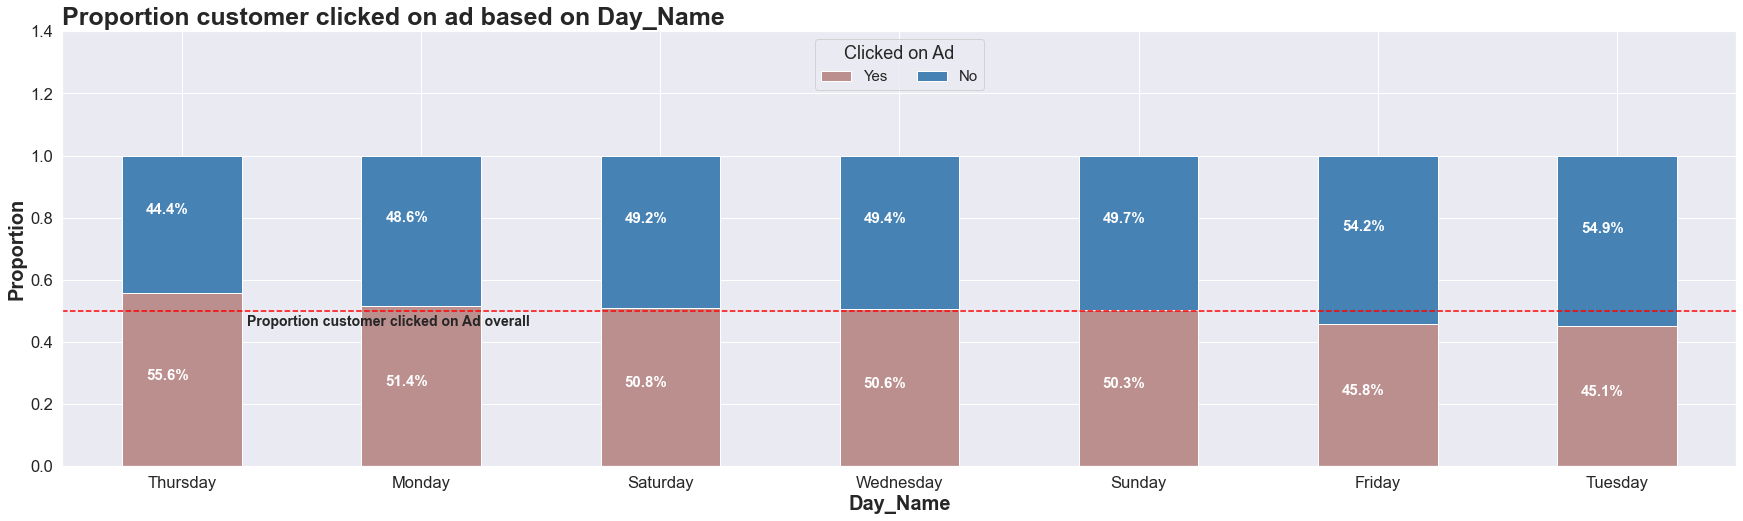

In [30]:
stackedbar('Day_Name')

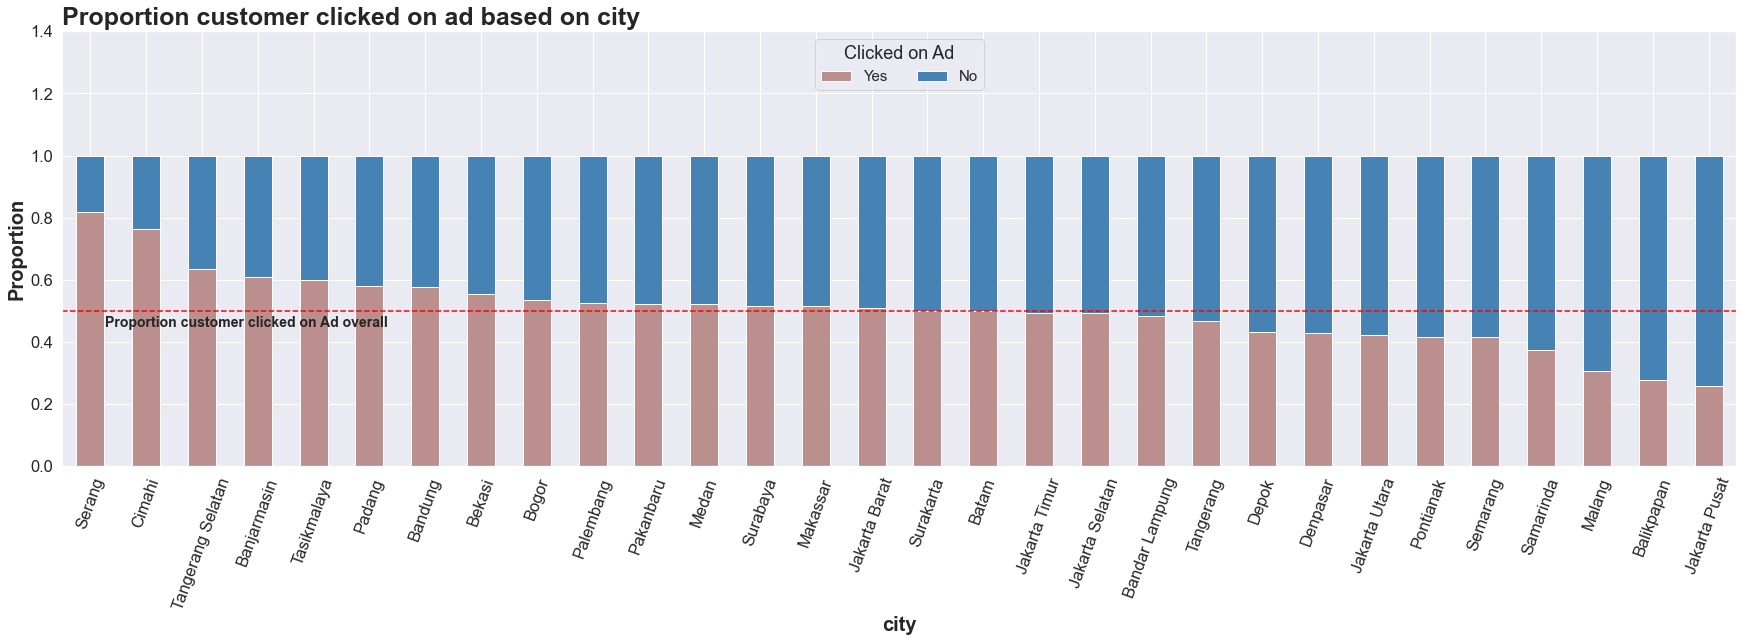

In [31]:
stackedbar1('city')

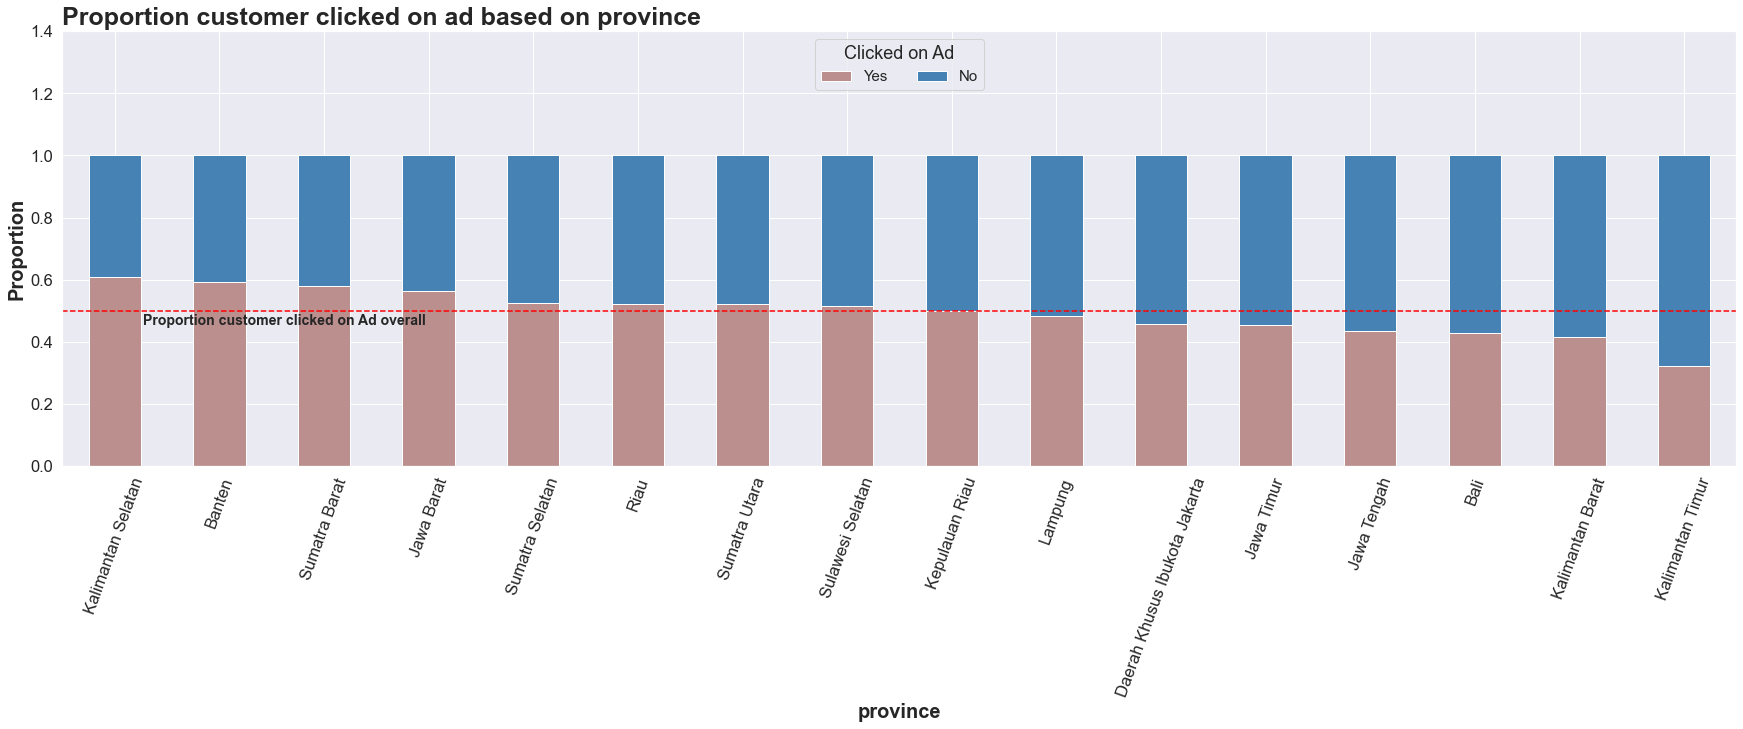

In [32]:
stackedbar1('province')

## Multivariate Analysis

(20.0, 120.0)

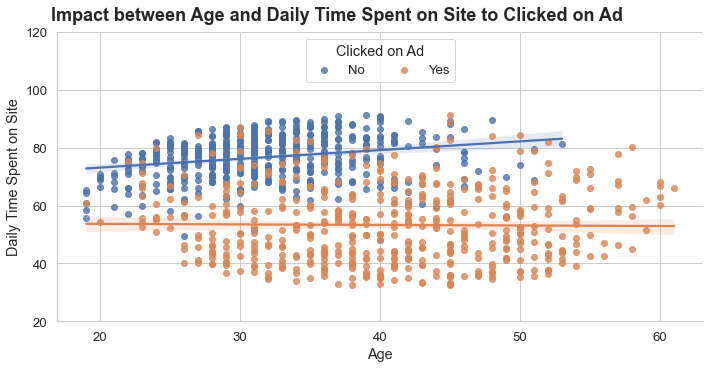

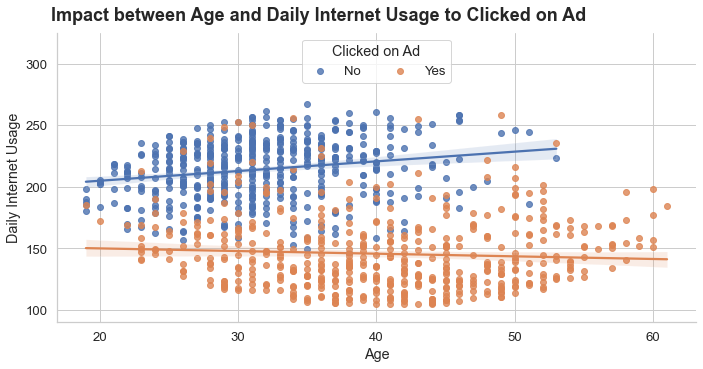

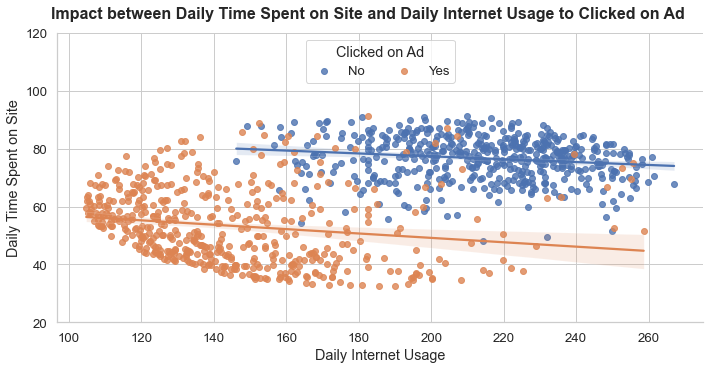

In [33]:
dataset = df[['Daily Time Spent on Site', 'Age',  'Daily Internet Usage','Clicked on Ad']]
sns.set(font_scale=1.2)
sns.set_style('whitegrid')
sns.lmplot(x ='Age', y ='Daily Time Spent on Site', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=16.5, y=124, s='Impact between Age and Daily Time Spent on Site to Clicked on Ad', fontsize=18, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(20,120)

sns.lmplot(x ='Age', y ='Daily Internet Usage', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=16.5, y=335, s='Impact between Age and Daily Internet Usage to Clicked on Ad', fontsize=18, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(90,325)

sns.lmplot(x ='Daily Internet Usage', y ='Daily Time Spent on Site', data = dataset, 
           hue ='Clicked on Ad', markers =['o', 'o'],height=5, aspect=2, legend=False)
plt.text(x=95, y=125, s='Impact between Daily Time Spent on Site and Daily Internet Usage to Clicked on Ad', fontsize=16, weight='bold')
plt.legend(title ='Clicked on Ad', loc = 'upper center', ncol = 2)
plt.ylim(20,120)

- Customer yang berusia sekitar 25-55 tahun dan yang menghabiskan waktu dari 30-70 menit per hari berada di internet merupakan customer yang melakukan clicked pada ad. Sedangkan pada customeryang berusia 20-40 tahun dan menghabiskan waku 70-90 menit per hari untuk berada di internet merupakan customer yang tidak melakukan clicked pada Ad. Dapat dilihat bahwa, semakin tinggi usia customer dan semakin sebentar untuk menghabiskan waktu berada di internet, cenderung melakukan clicked pad Ad. Sedangkan semakin tinggi usia customer dan semakin lama daily time spent on site, cenderung untuk tidak melakukan on Site. 

- Semakin tinggi usia customer dan penggunaan internet harian semakin sedikit, customer cenderung untuk melakukan clicked pada Ad. Sedangkan semakin tinggi usia customer dan semakin banyak penggunaan internet harian, cenderung untuk tidak melakukan clicked pada Ad

- Sebagian besar customer pengguna internet harian antara 110 - 170 dan menghabiskan waktu di website selama 30-70 menit per hari merupakan customer yang melakukan click pada Ad. Sedangkan sebagian besar customer yang pengguna internet harian antara 180 -260 dan menghabiskan waktu antara 60-90 menit per hari berada di website merupakan customer yang tidak melakukan clicked pada Ad

### Heatmap Correlation

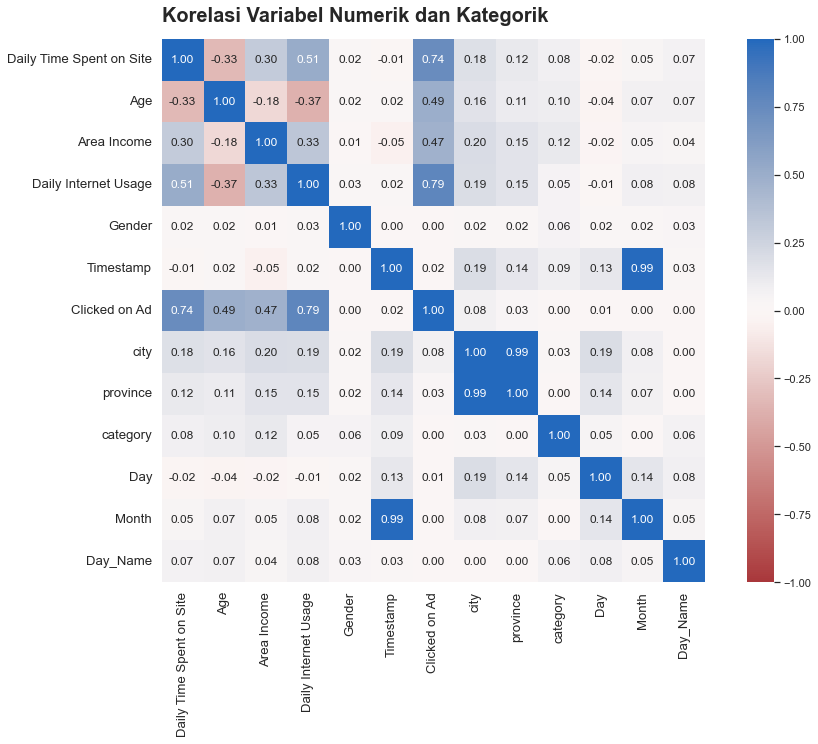

In [34]:
from dython.nominal import associations
fig, ax = plt.subplots(figsize =(15,10))
sns.set(font_scale=1)
plt.text(x=0,y=-0.4,s="Korelasi Variabel Numerik dan Kategorik",fontsize=20,weight='bold')
# Estimate and generate Cramer's V association plot
cramers_v = associations(df, nom_nom_assoc = 'cramer',cmap = "vlag_r", ax=ax)
plt.show()

- Ada beberapa variabel yang redundant antara lain : Month dengan Timestamp dan City dengan Province
- Variabel redundant yang memiliki korelasi paling lemah dengan variabel target akan didrop seperti variabel Month dan Province
- Variabel **age dan income memiliki korelasi positive yang sedang dengan Clicked on Ad**
- Variabel **daily time spent on site dan daily internet usage memiliki korelasi positive yang kuat dengan Clicked on Ad**
- Variabel daily time spent on site dan daily internet usage dengan age memiliki korelasi negative sedang 
- Variabel daily time spent on site dan area income, memiliki korelasi positive sedang dengan variabel daily internet usage 
- Variabel daily time spent on site dengan area income memiliki korelasi positive sedang

In [35]:
df = df.drop(['Month','province'], axis=1)

### Uji statistik

In [36]:
yes_clicked = df[df["Clicked on Ad"]=='Yes']
no_clicked = df[df["Clicked on Ad"]=='No']
list=[]
list_kolom = []
fitur = numeric.columns
for i in fitur:
    stat, p= st.f_oneway(yes_clicked[i], no_clicked[i])
    list.append(p)
list
print('Hasil Uji Statistik ANOVA :')
for i in range(0,len(fitur)):
    if list[i] > 0.05:
        result =  "Terima H0"
        print(result,fitur[i],'p-value',list[i])
        kolom = fitur[i]
        list_kolom.append(kolom)
    else:
        result =  "Terima H1"
        print(result,fitur[i],'p-value',list[i])
print("")
print('Kolom numerik yang akan didrop berdasarkan uji statistik')
print(list_kolom)

Hasil Uji Statistik ANOVA :
Terima H1 Daily Time Spent on Site p-value 1.4930331411686328e-175
Terima H1 Age p-value 3.1298083092905155e-62
Terima H1 Area Income p-value 2.248973881598795e-57
Terima H1 Daily Internet Usage p-value 3.2356732468665635e-210
Terima H0 Day p-value 0.8678227400097878

Kolom numerik yang akan didrop berdasarkan uji statistik
['Day']


- Variabel Day tidak berpengaruh terhadap variabel target Clicked on Ad sedemikian sehingga akan didrop

In [37]:
df = df.drop(['Day'], axis=1)

- Telah dilakukan feature engineering/extraction terhadap variabel Timestamp sedemikian sehingga akan didrop

In [38]:
df = df.drop(['Timestamp'], axis=1)

In [39]:
df.shape

(1000, 9)

# Data Preprocessing

## Handling Outlier

In [40]:
numeric.columns

Index(['Daily Time Spent on Site', 'Age', 'Area Income',
       'Daily Internet Usage', 'Day'],
      dtype='object')

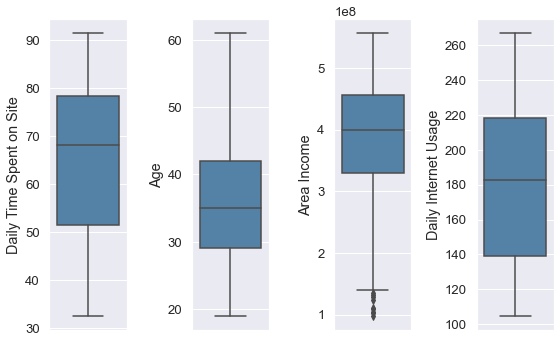

In [41]:
features = numeric.columns.tolist()
features.remove('Day')

for i in range(0, len(features)):
    plt.rcParams['figure.figsize'] = (10,5)
    sns.set(font_scale=1.2)
    plt.subplot(1,5,i+1)
    sns.boxplot(y=df[features[i]], color='Steelblue')
    plt.ylabel(features[i])
    plt.xticks(rotation = 45)
    plt.tight_layout()

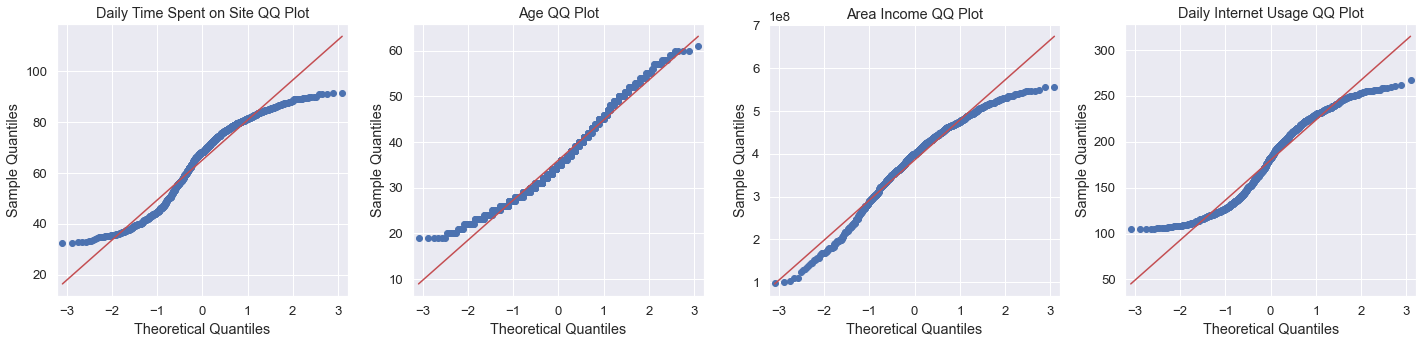

In [42]:
import statsmodels.api as sm
features = numeric.columns.tolist()
features.remove('Day')

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, figsize=(20, 5))
for i, ax in zip(features, np.ravel(axes)):
    sm.qqplot(df[i], line='s', ax=ax)
    ax.set_title(f'{i} QQ Plot')
    plt.tight_layout()

- Tidak ada outlier bertipe global pada variabel numerik

## Feature Encoding

Strategi feature encoding 
- Day_Name dan Gender akan diencoding menggunakan Label Encoding
- City dan Category akan diencoding menggunakan one hot encoding 
- Variabel numerik akan diencoding menggunakan standard scaler

In [43]:
ord_cols = ['Day_Name', 'Gender']
ohe_cols = ['city', 'category']
num_cols = ['Daily Time Spent on Site', 'Age', 'Area Income', 'Daily Internet Usage']

In [44]:
df['Clicked on Ad'] = np.where(df['Clicked on Ad']=='Yes',1,0)

In [45]:
X = df[num_cols+ord_cols+ohe_cols]
y = df['Clicked on Ad']


In [46]:
from sklearn.model_selection import train_test_split

# X = X[num_cols+ord_cols+ohe_cols]
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,test_size=0.2, random_state=42)

In [47]:
#Ordinal Encoder
ordinal_encoder = OrdinalEncoder(categories = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                                               ["Laki-Laki","Perempuan"]])
ord_pipe = Pipeline([('ordinal_encoder', ordinal_encoder)])

#Numeric 
scaler = StandardScaler()
num_pipe = Pipeline([
    ('scaler', scaler)])

#Onehot
onehot = OneHotEncoder()
ohe_pipe = Pipeline([('onehot_encoder', onehot)])

In [48]:
from sklearn.preprocessing import FunctionTransformer

In [49]:
preprocessor = ColumnTransformer(
    [
     ('num_pipe', num_pipe, num_cols),
     ('ord_pipe', ord_pipe, ord_cols),
     ('ohe_pipe', ohe_pipe, ohe_cols)
     ]
    )

In [50]:
preprocessor

ColumnTransformer(transformers=[('num_pipe',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['Daily Time Spent on Site', 'Age',
                                  'Area Income', 'Daily Internet Usage']),
                                ('ord_pipe',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Monday',
                                                                              'Tuesday',
                                                                              'Wednesday',
                                                                              'Thursday',
                                                                              'Friday',
                                                                              'Saturday',
                                                                              'Sunday'],
                                                                             ['Laki-Laki',
                                                                              'Perempuan']]))]),
                                 ['Day_Name', 'Gender']),
                                ('ohe_pipe',
                                 Pipeline(steps=[('onehot_encoder',
                                                  OneHotEncoder())]),
                                 ['city', 'category'])])

In [51]:
X_train.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Day_Name,Gender,city,category
747,49.13,32,287680190.0,120.49,Friday,Perempuan,Bekasi,Finance
586,78.29,38,404914720.0,252.07,Tuesday,Perempuan,Jakarta Utara,Furniture
519,35.00,40,322236110.0,151.25,Saturday,Laki-Laki,Tangerang,Health
770,71.14,30,488308170.0,224.82,Tuesday,Perempuan,Depok,House
600,84.00,48,328079710.0,136.21,Sunday,Laki-Laki,Tangerang,House


In [52]:
X_train_encoding = preprocessor.fit_transform(X_train)
X_test_encoding = preprocessor.transform(X_test)

In [53]:
all_columns = num_cols + ord_cols + pd.get_dummies(X_train[ohe_cols]).columns.tolist()

In [54]:
X_train_encoding = X_train_encoding.toarray()
X_train_encod = pd.DataFrame(X_train_encoding, columns= all_columns)

In [55]:
X_test_encoding = X_test_encoding.toarray()
X_test_encod = pd.DataFrame(X_test_encoding, columns= all_columns)

### Without Scaling

In [56]:
X_train_no = X_train[ord_cols+ohe_cols]
X_test_no = X_test[ord_cols+ohe_cols]

In [57]:
preprocessor_without_scaling = ColumnTransformer(
    [
     ('ord_pipe', ord_pipe, ord_cols),
     ('ohe_pipe', ohe_pipe, ohe_cols)
     ]
    )

In [58]:
preprocessor_without_scaling

ColumnTransformer(transformers=[('ord_pipe',
                                 Pipeline(steps=[('ordinal_encoder',
                                                  OrdinalEncoder(categories=[['Monday',
                                                                              'Tuesday',
                                                                              'Wednesday',
                                                                              'Thursday',
                                                                              'Friday',
                                                                              'Saturday',
                                                                              'Sunday'],
                                                                             ['Laki-Laki',
                                                                              'Perempuan']]))]),
                                 ['Day_Name', 'Gender']),
                                ('ohe_pipe',
                                 Pipeline(steps=[('onehot_encoder',
                                                  OneHotEncoder())]),
                                 ['city', 'category'])])

In [59]:
X_test_no.shape

(200, 4)

In [60]:
X_train_without = preprocessor_without_scaling.fit_transform(X_train_no).toarray()
cat_columns = ord_cols + pd.get_dummies(X_train_no[ohe_cols]).columns.tolist()
X_train_without = pd.DataFrame(X_train_without, columns= cat_columns)

In [61]:
fitur = num_cols 
X_train_num = X_train.copy()
X_train_num = X_train_num.reset_index()
X_train_num = X_train_num.drop('index', axis=1)

for i in num_cols:
    X_train_without[i] = X_train_num[i]

In [62]:
X_train_without.head()

,Day_Name,Gender,city_Balikpapan,city_Bandar Lampung,city_Bandung,city_Banjarmasin,city_Batam,city_Bekasi,city_Bogor,city_Cimahi,...,category_Food,category_Furniture,category_Health,category_House,category_Otomotif,category_Travel,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage
0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,49.13,32,287680190.0,120.49
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,78.29,38,404914720.0,252.07
2,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,35.00,40,322236110.0,151.25
3,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,71.14,30,488308170.0,224.82
4,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,84.00,48,328079710.0,136.21


In [63]:
X_test_without = preprocessor_without_scaling.transform(X_test_no).toarray()
cat_columns = ord_cols + pd.get_dummies(X_test_no[ohe_cols]).columns.tolist()
X_test_without = pd.DataFrame(X_test_without, columns= cat_columns)

In [64]:
fitur = num_cols 
X_test_num = X_test.copy()
X_test_num = X_test_num.reset_index()
X_test_num = X_test_num.drop('index', axis=1)

for i in fitur:
    X_test_without[i] = X_test_num[i]

# Modeling

- Metric yang digunakan adalah F1 Score

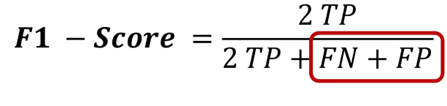

- Membuat model yang sekecil mungkin salah prediksi pada customer yang kemungkinan clicked on Ad serta salah prediksi pada customer yang tidak melakukan clicked on Ad. Sehingga tidak kehilangan potensial customer dan meminimumkan customer yang tidak melakukan clicked on Ad

In [65]:
#modelling with scoring metrics
def cross_validation(model):
    model_name = []
    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []
    
    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []
    
    cv_f1_mean = []
    cv_f1_std = []
    training_f1 = []
    
    cv_roc_auc_mean = []
    cv_roc_auc_std = []
    training_roc_auc = []

    
    for name, model in models:
        model_name.append(name)

        #scoring
        scoring= ['accuracy','recall', 'precision', 'f1', 'roc_auc']
        
        #cross_validate 
        cv_score = cross_validate(model, X_train_encod, y_train, scoring=scoring, cv=5, n_jobs = -1)
        
        # training
        model.fit(X_train_encod, y_train)
        y_pred = model.predict(X_train_encod)

        training_accuracy.append(accuracy_score(y_train,y_pred))
        training_recall.append(recall_score(y_train,y_pred))
        training_precision.append(precision_score(y_train, y_pred))
        training_f1.append(f1_score(y_train, y_pred))
        training_roc_auc.append(roc_auc_score(y_train, y_pred))
        
        #tes
        cv_accuracy_mean.append(abs(cv_score['test_accuracy']).mean())
        cv_accuracy_std.append(abs(cv_score['test_accuracy']).std())
        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())
        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())
        cv_f1_mean.append(abs(cv_score['test_f1']).mean())
        cv_f1_std.append(abs(cv_score['test_f1']).std())
        cv_roc_auc_mean.append(abs(cv_score['test_roc_auc']).mean())
        cv_roc_auc_std.append(abs(cv_score['test_roc_auc']).std())
   
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy' : training_accuracy,
        'CV Accuracy (mean)' : cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)': cv_recall_mean,
        'CV Recall (std)': cv_recall_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)' : cv_precision_mean,
        'CV Precision (std)' : cv_precision_std,
        'Training F1' : training_f1,
        'CV F1 (mean)' : cv_f1_mean,
        'CV F1 (std)' : cv_f1_std,
        'Training AUC_ROC' : training_roc_auc,
        'CV AUC_ROC (mean)' : cv_roc_auc_mean,
        'CV AUC_ROC (std)' : cv_roc_auc_std,
    })

In [66]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

In [67]:
#assign model ke dalam variabel
models = [
    ['Logistic Regression', LogisticRegression(random_state=42)],
    ['XGB', XGBClassifier(verbosity=0)],
    ['Decision Tree', DecisionTreeClassifier(random_state=42)],
    ['Random Forest', RandomForestClassifier(random_state=42)],
    ['Naive Bayes', GaussianNB()],
    ['LGBM', LGBMClassifier(random_state=42, n_jobs=-1)],
    ['Adaboost', AdaBoostClassifier(random_state=42)],
    ['KNN', KNeighborsClassifier()]
]

In [68]:
%%time
cv_result = cross_validation(models)
cv_result

CPU times: total: 1.3 s
Wall time: 5.4 s


,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Recall,CV Recall (mean),CV Recall (std),Training Precision,CV Precision (mean),CV Precision (std),Training F1,CV F1 (mean),CV F1 (std),Training AUC_ROC,CV AUC_ROC (mean),CV AUC_ROC (std)
0,Logistic Regression,0.97125,0.96625,0.011592,0.9625,0.9600,0.020000,0.979644,0.972378,0.014108,0.970996,0.965984,0.011937,0.97125,0.991844,0.002150
1,XGB,1.00000,0.95125,0.013346,1.0000,0.9475,0.020000,1.000000,0.954897,0.015996,1.000000,0.951028,0.013604,1.00000,0.990531,0.003037
2,Decision Tree,1.00000,0.93500,0.005000,1.0000,0.9350,0.031024,1.000000,0.936565,0.026787,1.000000,0.934907,0.005811,1.00000,0.935000,0.005000
3,Random Forest,1.00000,0.95750,0.012748,1.0000,0.9550,0.028062,1.000000,0.960143,0.013539,1.000000,0.957229,0.013501,1.00000,0.990250,0.005484
4,Naive Bayes,0.90000,0.84250,0.027214,0.9175,0.8500,0.079057,0.886473,0.842514,0.045866,0.901720,0.842225,0.033337,0.90000,0.882906,0.017691
5,LGBM,1.00000,0.95625,0.005590,1.0000,0.9500,0.019365,1.000000,0.962597,0.016782,1.000000,0.955943,0.005847,1.00000,0.990375,0.004859
6,Adaboost,0.98250,0.95125,0.012748,0.9725,0.9450,0.029155,0.992347,0.957528,0.017197,0.982323,0.950788,0.013609,0.98250,0.983656,0.006860
7,KNN,0.97125,0.96000,0.014031,0.9500,0.9300,0.023184,0.992167,0.989364,0.010069,0.970626,0.958639,0.014792,0.97125,0.981000,0.007643


- Setelah dilakukan crossval pada beberapa model, akan dipilih algoritma Adaboost karena AUC_ROC dari train dan crosval tidak berbeda signifikan, hanya selisih sedikit. Nilai F1 Score Training dan CV juga tinggi.

### Tuning Hyperparameter Adaboost with Standarization

In [69]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [70]:
%%time
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 2000)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned = RandomizedSearchCV(ab, hyperparameters, cv=5, scoring='f1', random_state=42)
ab_tuned.fit(X_train_encod,y_train)

print(ab_tuned.best_params_)
print(ab_tuned.score(X_train_encod, y_train), ab_tuned.best_score_)

{'n_estimators': 1176, 'learning_rate': 0.0681608040201005, 'algorithm': 'SAMME.R'}
0.9912170639899623 0.962125429260376
CPU times: total: 1min 4s
Wall time: 1min 5s


Adaboost Model - Score Before Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.99      0.97      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Adaboost Model - Score After Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



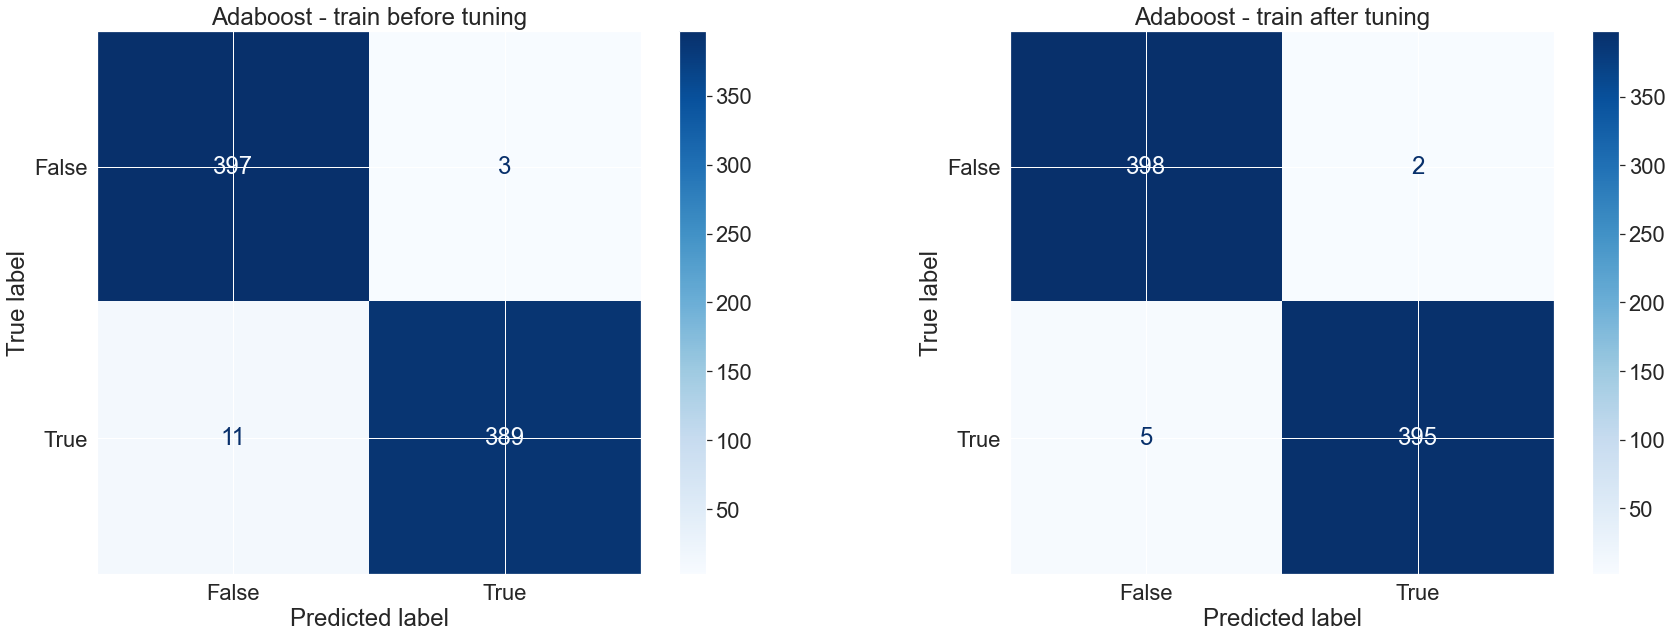

In [71]:
plt.rcParams['figure.figsize'] = (30,10)
sns.set(font_scale=2)
fig, ax = plt.subplots(1,2)
ax[0].set_title("Adaboost - train before tuning")
ax[1].set_title("Adaboost - train after tuning")

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train_encod, y_train)
y_pred_train_ab = ab.predict(X_train_encod)


adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate= 0.0681608040201005, algorithm='SAMME.R')
adaboost_rs.fit(X_train_encod, y_train)
y_pred_train_abrs = adaboost_rs.predict(X_train_encod)

print("Adaboost Model - Score Before Hyperparameter Tuning")
print(metrics.classification_report(y_train,y_pred_train_ab))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train_ab), 
display_labels = [False, True]).plot(ax=ax[0], cmap='Blues')

print("Adaboost Model - Score After Hyperparameter Tuning")
print(metrics.classification_report(y_train,y_pred_train_abrs))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train_abrs), 
display_labels = [False, True]).plot(ax=ax[1], cmap='Blues');

Adaboost Model - Score Use Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



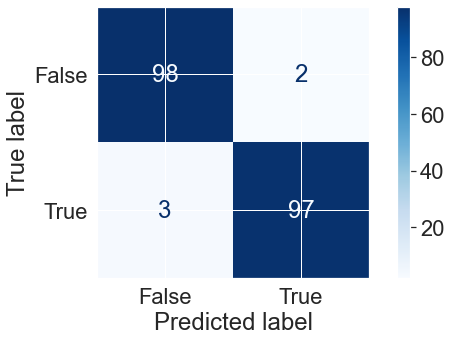

In [72]:
plt.rcParams['figure.figsize'] = (10,5)
sns.set(font_scale=2)

adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate= 0.0681608040201005, algorithm='SAMME.R')
adaboost_rs.fit(X_train_encod, y_train)
y_pred_test_abrs = adaboost_rs.predict(X_test_encod)

cmap = ListedColormap(['Lightcoral','Midnightblue'])
print("Adaboost Model - Score Use Hyperparameter Tuning")
print(metrics.classification_report(y_test,y_pred_test_abrs))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test_abrs), 
display_labels = [False, True]).plot(cmap = 'Blues');

### Tuning Hyperparameter Adaboost 'without' Standarization

In [73]:
#modelling with scoring metrics
def cross_validation_without_scalling(model):
    model_name = []
    cv_accuracy_mean = []
    cv_accuracy_std = []
    training_accuracy = []
    
    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []
    
    cv_f1_mean = []
    cv_f1_std = []
    training_f1 = []
    
    cv_roc_auc_mean = []
    cv_roc_auc_std = []
    training_roc_auc = []

    
    for name, model in models:
        model_name.append(name)

        #scoring
        scoring= ['accuracy','recall', 'precision', 'f1', 'roc_auc']
        
        #cross_validate 
        cv_score = cross_validate(model, X_train_without, y_train, scoring=scoring, cv=5, n_jobs = -1)
        
        # training
        model.fit(X_train_without, y_train)
        y_pred = model.predict(X_train_without)

        training_accuracy.append(accuracy_score(y_train,y_pred))
        training_recall.append(recall_score(y_train,y_pred))
        training_precision.append(precision_score(y_train, y_pred))
        training_f1.append(f1_score(y_train, y_pred))
        training_roc_auc.append(roc_auc_score(y_train, y_pred))
        
        #tes
        cv_accuracy_mean.append(abs(cv_score['test_accuracy']).mean())
        cv_accuracy_std.append(abs(cv_score['test_accuracy']).std())
        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())
        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())
        cv_f1_mean.append(abs(cv_score['test_f1']).mean())
        cv_f1_std.append(abs(cv_score['test_f1']).std())
        cv_roc_auc_mean.append(abs(cv_score['test_roc_auc']).mean())
        cv_roc_auc_std.append(abs(cv_score['test_roc_auc']).std())
   
    return pd.DataFrame({
        'Model': model_name,
        'Training Accuracy' : training_accuracy,
        'CV Accuracy (mean)' : cv_accuracy_mean,
        'CV Accuracy (std)' : cv_accuracy_std,
        'Training Recall' : training_recall,
        'CV Recall (mean)': cv_recall_mean,
        'CV Recall (std)': cv_recall_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)' : cv_precision_mean,
        'CV Precision (std)' : cv_precision_std,
        'Training F1' : training_f1,
        'CV F1 (mean)' : cv_f1_mean,
        'CV F1 (std)' : cv_f1_std,
        'Training AUC_ROC' : training_roc_auc,
        'CV AUC_ROC (mean)' : cv_roc_auc_mean,
        'CV AUC_ROC (std)' : cv_roc_auc_std,
    })

In [74]:
%%time
cv_result = cross_validation_without_scalling(models)
cv_result

CPU times: total: 1.03 s
Wall time: 1.59 s


,Model,Training Accuracy,CV Accuracy (mean),CV Accuracy (std),Training Recall,CV Recall (mean),CV Recall (std),Training Precision,CV Precision (mean),CV Precision (std),Training F1,CV F1 (mean),CV F1 (std),Training AUC_ROC,CV AUC_ROC (mean),CV AUC_ROC (std)
0,Logistic Regression,0.5000,0.50000,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.5000,0.761531,0.026112
1,XGB,1.0000,0.95250,0.010155,1.0000,0.9475,0.020000,1.000000,0.957998,0.023939,1.000000,0.952304,0.009848,1.0000,0.990688,0.003256
2,Decision Tree,1.0000,0.93875,0.008292,1.0000,0.9350,0.025495,1.000000,0.943754,0.030075,1.000000,0.938578,0.007553,1.0000,0.938750,0.008292
3,Random Forest,1.0000,0.96125,0.010000,1.0000,0.9575,0.023184,1.000000,0.964912,0.008699,1.000000,0.960980,0.010647,1.0000,0.991203,0.004649
4,Naive Bayes,0.7025,0.70250,0.040620,0.5800,0.5800,0.062048,0.768212,0.768739,0.053308,0.660969,0.659779,0.053513,0.7025,0.761156,0.032260
5,LGBM,1.0000,0.95750,0.010753,1.0000,0.9525,0.026693,1.000000,0.963034,0.022210,1.000000,0.957220,0.011196,1.0000,0.991000,0.004426
6,Adaboost,0.9825,0.95125,0.012748,0.9725,0.9450,0.029155,0.992347,0.957528,0.017197,0.982323,0.950788,0.013609,0.9825,0.983656,0.006860
7,KNN,0.7650,0.63500,0.040039,0.7250,0.6025,0.072629,0.788043,0.645130,0.045867,0.755208,0.621179,0.050327,0.7650,0.675891,0.054736


- Dari beberapa algoritma, nilai Training AUC_ROC dan CV pada Adaboost hampir sama di angka 98%. Oleh karena itu akan dilakukan tuning hyperparameter pada model Adaboost

In [75]:
%%time
hyperparameters = dict(n_estimators = [int(x) for x in np.linspace(start = 50, stop = 2000, num = 2000)], # Jumlah iterasi
                       learning_rate = [float(x) for x in np.linspace(start = 0.001, stop = 0.1, num = 200)],  
                       algorithm = ['SAMME', 'SAMME.R']
                      )

# Init model
ab = AdaBoostClassifier(random_state=42)
ab_tuned_without = RandomizedSearchCV(ab, hyperparameters, cv=5, scoring='f1', random_state=42)
ab_tuned_without.fit(X_train_without,y_train)

print(ab_tuned_without.best_params_)
print(ab_tuned_without.score(X_train_without, y_train), ab_tuned_without.best_score_)

{'n_estimators': 1176, 'learning_rate': 0.0681608040201005, 'algorithm': 'SAMME.R'}
0.9912170639899623 0.962125429260376
CPU times: total: 1min 5s
Wall time: 1min 6s


Adaboost Model - Score Before Hyperparameter Tuning without Scaling
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       400
           1       0.99      0.97      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Adaboost Model - Score After Hyperparameter Tuning without Scaling
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



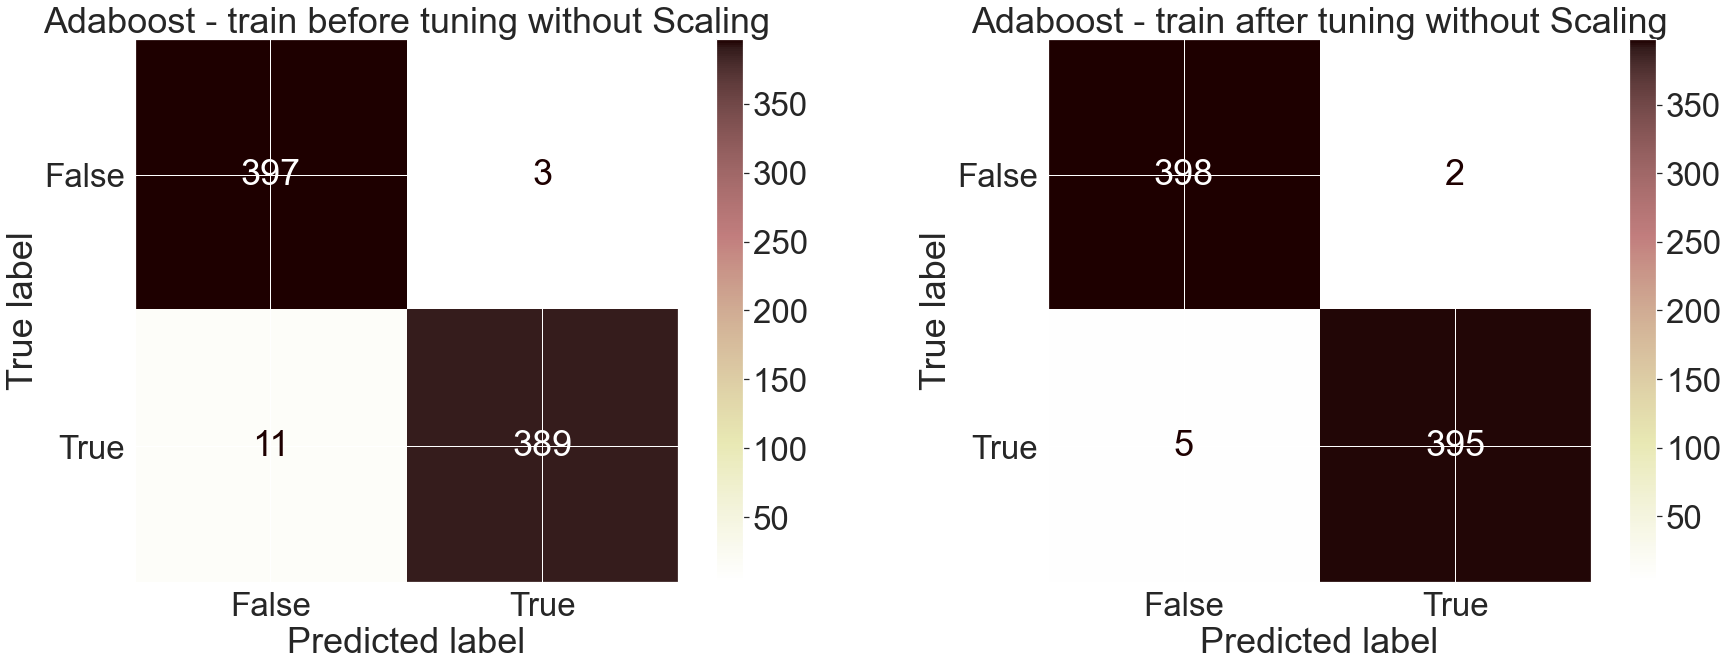

In [76]:
plt.rcParams['figure.figsize'] = (30,10)
sns.set(font_scale=3)
fig, ax = plt.subplots(1,2)
ax[0].set_title("Adaboost - train before tuning without Scaling")
ax[1].set_title("Adaboost - train after tuning without Scaling")

ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train_without, y_train)
y_pred_train_ab = ab.predict(X_train_without)


adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
adaboost_rs.fit(X_train_without, y_train)
y_pred_train_abrs = adaboost_rs.predict(X_train_without)

print("Adaboost Model - Score Before Hyperparameter Tuning without Scaling")
print(metrics.classification_report(y_train,y_pred_train_ab))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train_ab), 
display_labels = [False, True]).plot(ax=ax[0], cmap = 'pink_r')

print("Adaboost Model - Score After Hyperparameter Tuning without Scaling")
print(metrics.classification_report(y_train,y_pred_train_abrs))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_train, y_pred_train_abrs), 
display_labels = [False, True]).plot(ax=ax[1], cmap='pink_r');

Adaboost Model - Score Data Test without Standardization Use Hyperparameter Tuning
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



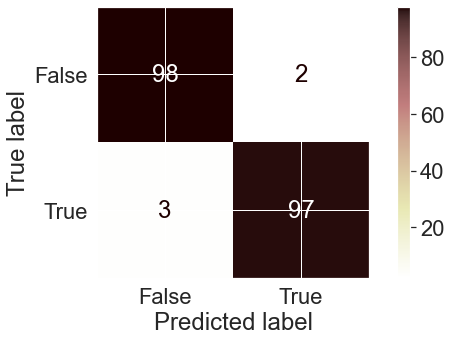

In [77]:
plt.rcParams['figure.figsize'] = (10,5)
sns.set(font_scale=2)

adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
adaboost_rs.fit(X_train_without, y_train)
y_test_abrs = adaboost_rs.predict(X_test_without)


cmap = ListedColormap(['Lightcoral','Midnightblue'])
print("Adaboost Model - Score Data Test without Standardization Use Hyperparameter Tuning")
print(metrics.classification_report(y_test,y_test_abrs))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_test, y_test_abrs), 
display_labels = [False, True]).plot(cmap = 'pink_r');

## Compare Model with Standarization and without Standarization

In [78]:
adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
model = adaboost_rs
model.fit(X_train_encod, y_train)
y_pred = model.predict(X_test_encod)
y_pred_proba = model.predict_proba(X_test_encod)
#Metric                                   
acc = round(accuracy_score(y_test,y_pred),3)
f1 = round(f1_score(y_test,y_pred),3)
roc_auc = round(roc_auc_score(y_test, y_pred_proba[:, 1]),3)

                                   
model2 = adaboost_rs
model.fit(X_train_without, y_train)
y_pred_without = model.predict(X_test_without)
y_pred_proba_without = model.predict_proba(X_test_without)                                  
#Metric                                   
acc_2 = round(accuracy_score(y_test,y_pred_without),3)
f1_2 = round(f1_score(y_test,y_pred_without),3)
roc_auc_2 = round(roc_auc_score(y_test, y_pred_proba_without[:, 1]),3)

compare = {
    'Model Adaboost in Data Test' : ['With Standarizationn', 'Without Standarization'],
    'Accuracy' :[acc, acc_2],
    'F1' : [f1, f1_2],
    'ROC_AUC' : [roc_auc, roc_auc_2]}

In [79]:
compare = pd.DataFrame(compare)

In [80]:
compare.to_excel('compare.xlsx')

In [81]:
compare

,Model Adaboost in Data Test,Accuracy,F1,ROC_AUC
0,With Standarizationn,0.975,0.975,0.985
1,Without Standarization,0.975,0.975,0.985


Adaboost Model - with Standarization
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200

Adaboost Model - without Standarization
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       100
           1       0.98      0.97      0.97       100

    accuracy                           0.97       200
   macro avg       0.98      0.97      0.97       200
weighted avg       0.98      0.97      0.97       200



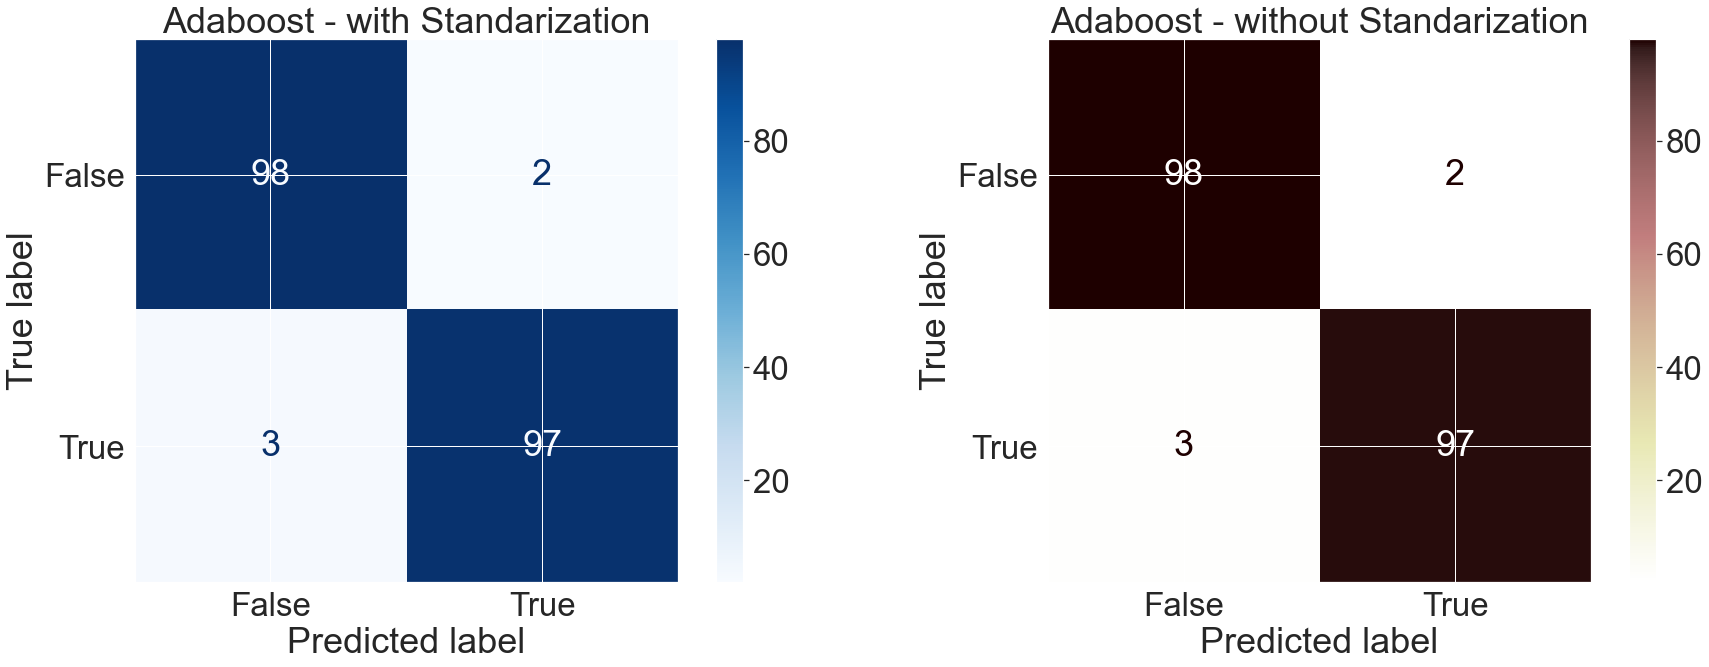

In [82]:
plt.rcParams['figure.figsize'] = (30,10)
sns.set(font_scale=3)
fig, ax = plt.subplots(1,2)
ax[0].set_title("Adaboost - with Standarization")
ax[1].set_title("Adaboost - without Standarization")

adaboost_rs = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
model = adaboost_rs
model.fit(X_train_encod, y_train)
y_pred = model.predict(X_test_encod)
y_pred_proba = model.predict_proba(X_test_encod)

model2 = adaboost_rs
model.fit(X_train_without, y_train)
y_pred_without = model.predict(X_test_without)
y_pred_proba_without = model.predict_proba(X_test_without)  


print("Adaboost Model - with Standarization")
print(metrics.classification_report(y_test,y_pred))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_test, y_pred), 
display_labels = [False, True]).plot(ax=ax[0], cmap= 'Blues')

print("Adaboost Model - without Standarization")
print(metrics.classification_report(y_test,y_pred_without))
metrics.ConfusionMatrixDisplay(
confusion_matrix = metrics.confusion_matrix(y_test, y_pred_without), 
display_labels = [False, True]).plot(ax=ax[1], cmap='pink_r');

Dengan menggunakan algoritma Adaboost dan telah dilakukan tuning hyperparameter, tidak ada perbedaan hasil dari confusion matrix dari kedua experiment, score di beberapa metrics pun juga tidak ada perbedaan. 


## Feature Importance

In [83]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_, index=X_train_encod.columns)
    sns.set(font_scale=1)
    ax = feat_importances.nlargest(20).plot(kind='barh', figsize=(6, 7), color = 'Steelblue')
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [84]:
model = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
model.fit(X_train_encod, y_train)
y_pred = model.predict(X_test_encod)#Check performa dari model

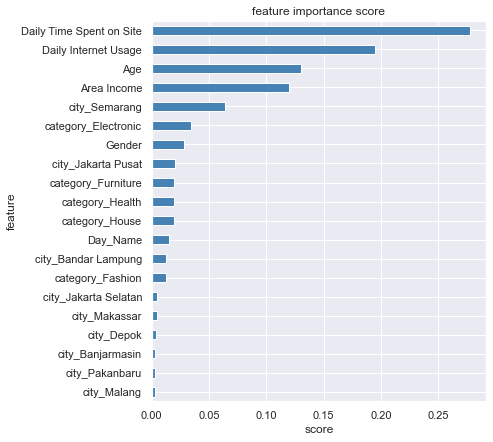

In [85]:
show_feature_importance(model)

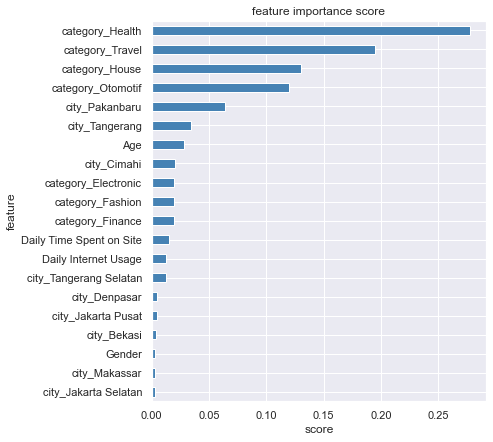

In [86]:
model1 = AdaBoostClassifier(random_state=42, n_estimators=1176, learning_rate=0.0681608040201005 , algorithm='SAMME.R')
model1.fit(X_train_without, y_train)
y_pred_without = model1.predict(X_test_without)#Check performa dari model
show_feature_importance(model1)

Ada perbedaan feature importance diantara keduanya. Jika tanpa standarisasi 2 fitur utama adalah category Health dan Travel, sedangkan jika menggunakan standarisasi 2 fitur utama keberhasilan marketing adalah penggunaan harian internet dan waktu yang dihabiskan saat berada di situs/platform


# Business Simulation & Recommendation

## Business Simulation

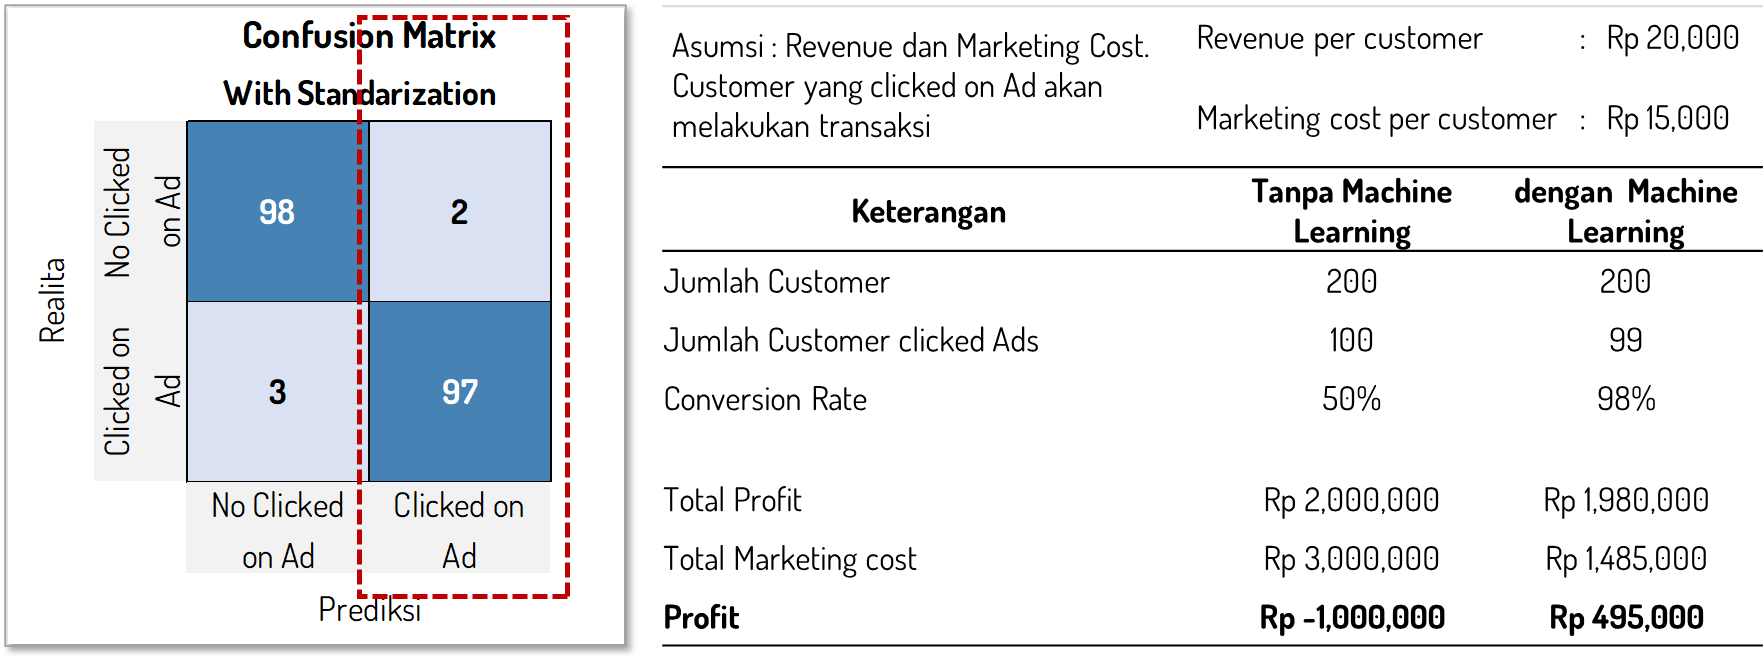

- Kemungkinan customer melakukan clicked on Ad dan bertransaksi adalah 50:50 jika tidak menggunakan model (berdasarkan data yang ada 50% customer akan clicked on Ad). 
- Jika menggunakan model pada Machine Learning, dari 200 customer diprediksi yang akan melakukan clicked on Ad adalah 99 orang, sehingga bisa menghemat cost marketing hingga setengahnya jika tanpa model. 

## Business Recommendation

- Customer kategori A merupakan customer yang berusia muda yang memiliki history penggunaan internet harian 150 menit ke atas dan menghabiskan waktu berada di situs selama > 60 menit
- Customer kategori B customer yang berusia lebih tua, memiliki history penggunaan internet harian < 175 menit dan menghabiskan waktu berada di situs/platform selama < 60 menit. 

Customer berusia muda dan memiliki history penggunaan internet lebih lama cenderung tidak melakukan klik/melihat iklan. Mungkin saja hal tersebut terjadi karena terbiasa melihat iklan di internet sehingga mengabaikannya, berbeda halnya dengan customer kategori B (usia lebih tua dari customer kategori A) memiliki history penggunaan internet lebih rendah namun melakukan klik pada iklan. 

1. Customer kategori B merupakan customer yang potensial untuk menerima marketing campaign melalui clicked on Ad. Sehingga dapat memasang iklan digital pada situs/platform yang sering dikunjungi customer kategori tersebut. 
2. Mengoptimalkan iklan pada kategori Finance, fashion dan otomotif. Karena customer sering melakukan klik pada iklan kategori tersebut
3. Iklan yang ditampilkan pada hari Kamis lebih sering diklik/dilihat customer sehingga dapat mengoptimalkan pada hari tersebut, karena hari Kamis dirasa cukup potensial untuk melakukan marketing campaign melalui iklan digital.
